<h3><center> Bartosz Cywiński, Łukasz Staniszewski </center></h3>
<h1><center> Analiza eksploracyjna danych</center><h1>

# I. ANALIZA W KONTEKŚCIE PRODUKTÓW

In [1]:
%load_ext autoreload
%autoreload 2

## I.1. Import tabeli

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from copy import copy
import scipy.stats as ss
from collections import Counter
plt.style.use('seaborn')


In [3]:
df_sessions = pd.read_json(path_or_buf='../data/raw/sessions.jsonl', lines=True)
df_products = pd.read_json(path_or_buf='../data/raw/products.jsonl', lines=True)
df_users = pd.read_json(path_or_buf='../data/raw/users.jsonl', lines=True)

In [4]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,NaN
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,20001.0
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0,NaN
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0,NaN
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0,NaN


In [5]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [7]:
df_users.head()

,user_id,name,city,street
0,102,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Poznań,al. Wrocławska 10
2,104,Radosław Ratka,Szczecin,pl. Nowa 89/04
3,105,Anastazja Oszust,Warszawa,ul. Częstochowska 80
4,106,Sylwia Nurek,Warszawa,al. Wiosenna 72


## I.2. Braki w danych

In [8]:
df_sessions.isnull().sum()

session_id              0
timestamp               0
user_id                 0
product_id              0
event_type              0
offered_discount        0
purchase_id         29479
dtype: int64

In [9]:
df_products.isnull().sum()

product_id       0
product_name     0
category_path    0
price            0
dtype: int64

Jak widać, jedyne nulle jakie posiadamy, nie są związane z brakami danych - związane są z logiką biznesową sklepu - nie będziemy zapisywać sprzedaży, jeśli nic nie zostało kupione. W dalszej analizie nie będzie nam potrzebna informacja o id_zakupu - wyrzućmy.

In [10]:
df_sessions = df_sessions.drop(columns='purchase_id')

In [11]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0


## I.3. Typy danych

In [12]:
df_sessions.dtypes

session_id                   int64
timestamp           datetime64[ns]
user_id                      int64
product_id                   int64
event_type                  object
offered_discount             int64
dtype: object

In [13]:
df_products.dtypes

product_id         int64
product_name      object
category_path     object
price            float64
dtype: object

+ Podstawowe informacje na temat numerycznych atrybutów tabel:

In [15]:
df_products.describe()

,product_id,price
count,319.000000,319.000000
mean,1160.000000,247.787962
std,92.231593,813.788548
min,1001.000000,1.000000
25%,1080.500000,24.990000
50%,1160.000000,41.000000
75%,1239.500000,92.995000
max,1319.000000,7639.000000


In [16]:
df_sessions.describe()

,session_id,user_id,product_id,offered_discount
count,35004.000000,35004.000000,35004.000000,35004.000000
mean,4865.495572,197.865730,1129.404954,5.177551
std,2760.309751,59.231817,119.334323,7.161938
min,124.000000,102.000000,1001.000000,0.000000
25%,2483.750000,147.000000,1036.000000,0.000000
50%,4846.000000,193.000000,1067.000000,0.000000
75%,7248.250000,247.000000,1278.000000,10.000000
max,9650.000000,301.000000,1319.000000,20.000000


## I.3. Eksploracja kategorii produktów

In [17]:
df_products['category_path'].unique()

array(['Telefony i akcesoria;Telefony stacjonarne',
       'Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne',
       'Gry i konsole;Gry na konsole;Gry Xbox 360',
       'Komputery;Monitory;Monitory LCD',
       'Telefony i akcesoria;Telefony komórkowe',
       'Gry i konsole;Gry na konsole;Gry PlayStation3',
       'Gry i konsole;Gry komputerowe',
       'Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące',
       'Sprzęt RTV;Video;Odtwarzacze DVD',
       'Komputery;Tablety i akcesoria;Tablety',
       'Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4',
       'Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D',
       'Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV',
       'Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe',
       'Sprzęt RTV;Audio;Słuchawki'], dtype=object)

Zależnośc liczby produktów w sklepie od danej ściezki kategorii:

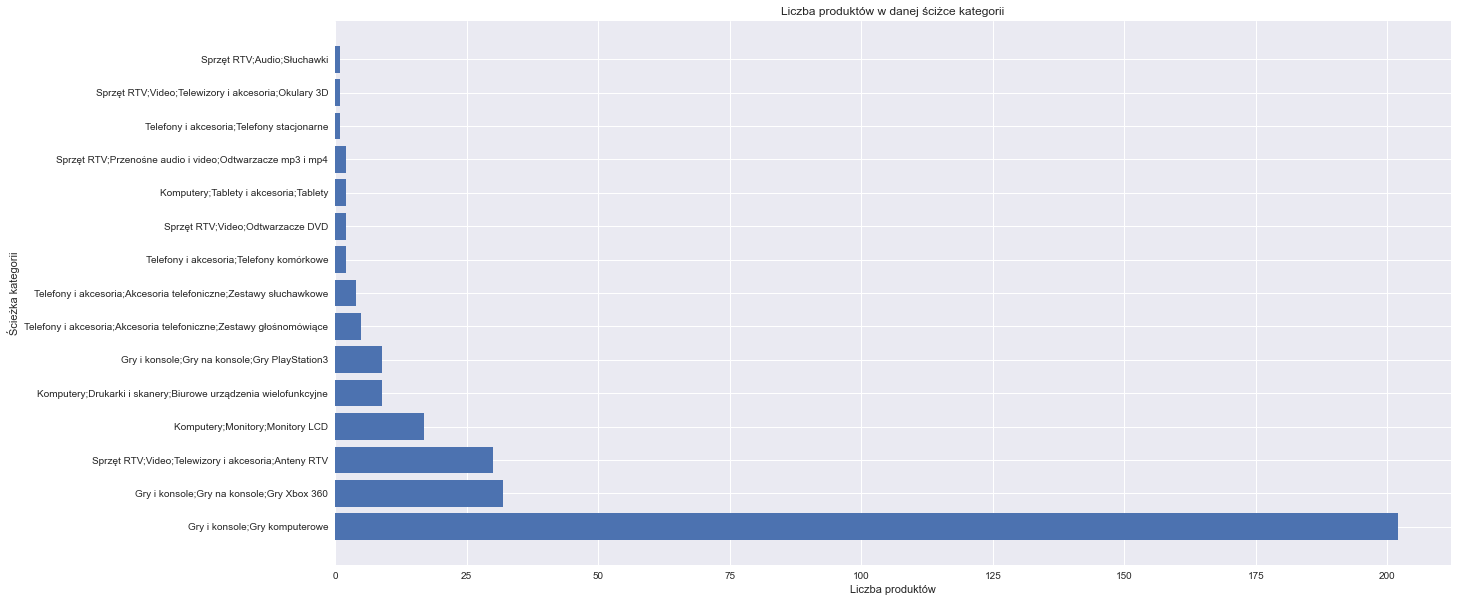

In [18]:
plt.figure(figsize=(20, 10))
plt.barh(df_products['category_path'].value_counts().keys(), df_products['category_path'].value_counts())
plt.title('Liczba produktów w danej ściżce kategorii')
plt.xlabel('Liczba produktów')
plt.ylabel('Ścieżka kategorii')
plt.show()

Zależność średniej ceny produktów z danej ściezki kategorii:

In [19]:
df_categories_means = df_products.groupby('category_path')['price'].mean()
df_categories_means

category_path
Gry i konsole;Gry komputerowe                                          37.995248
Gry i konsole;Gry na konsole;Gry PlayStation3                          87.630000
Gry i konsole;Gry na konsole;Gry Xbox 360                              76.674375
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne       4238.504444
Komputery;Monitory;Monitory LCD                                       955.805294
Komputery;Tablety i akcesoria;Tablety                                2066.995000
Sprzęt RTV;Audio;Słuchawki                                            553.000000
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4               71.850000
Sprzęt RTV;Video;Odtwarzacze DVD                                      151.000000
Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV                    110.775667
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D                     99.990000
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące     217.350000
Telefony i akc

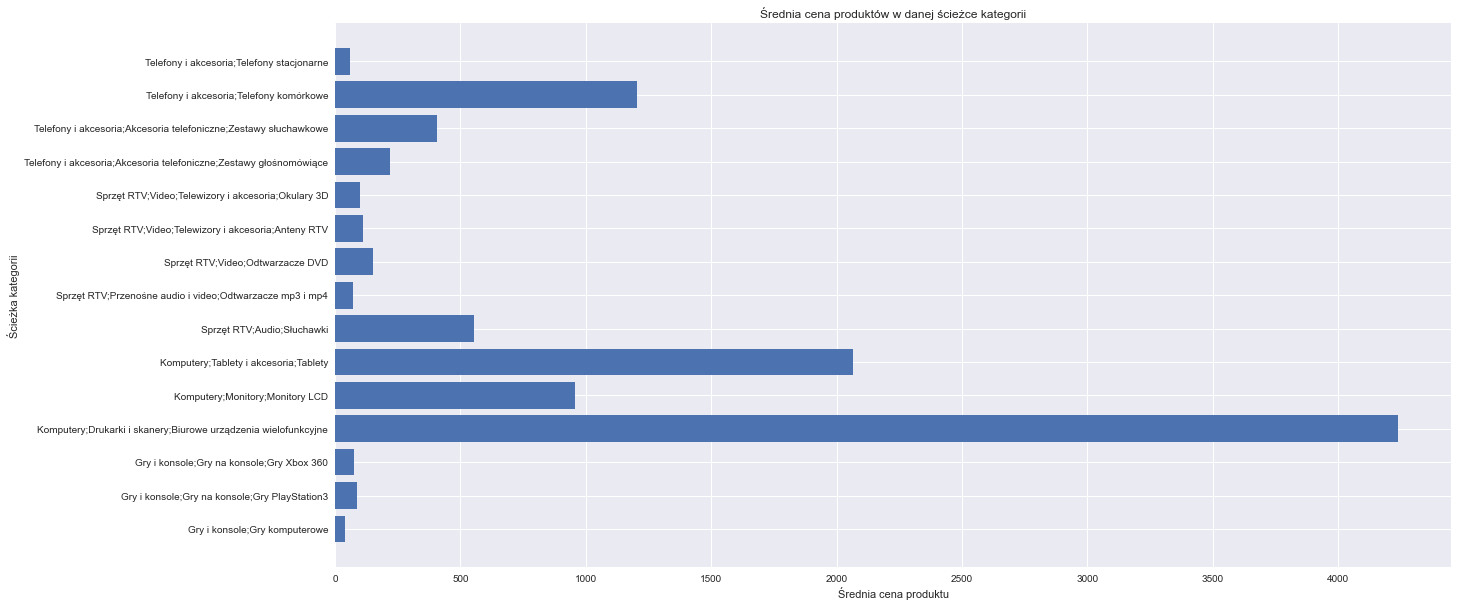

In [20]:
plt.figure(figsize=(20, 10))
plt.barh(df_products['category_path'].value_counts().keys().sort_values(), df_categories_means)
plt.title('Średnia cena produktów w danej ścieżce kategorii')
plt.xlabel('Średnia cena produktu')
plt.ylabel('Ścieżka kategorii')
plt.show()

Głębsze rozdzielenie kategorii - poza kategoriami na najniższym poziomie, dodawane sa te z wyższych poziomów:

In [21]:
df_products_categorical = df_products.category_path.str.get_dummies(';')
df_products_categorical = df_products_categorical.rename({name: "Kategoria:" + name for name in df_products_categorical.columns},axis='columns')
df_products_categorical.head()

,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,Kategoria:Gry Xbox 360,Kategoria:Gry i konsole,Kategoria:Gry komputerowe,Kategoria:Gry na konsole,...,Kategoria:Słuchawki,Kategoria:Tablety,Kategoria:Tablety i akcesoria,Kategoria:Telefony i akcesoria,Kategoria:Telefony komórkowe,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


Statystyka liczby produktów w ramach wszystkich kategorii/podkategorii:

In [22]:
rows_on_cat = {column_name: df_products_categorical.loc[df_products_categorical[column_name] == 1] for column_name in df_products_categorical.columns}

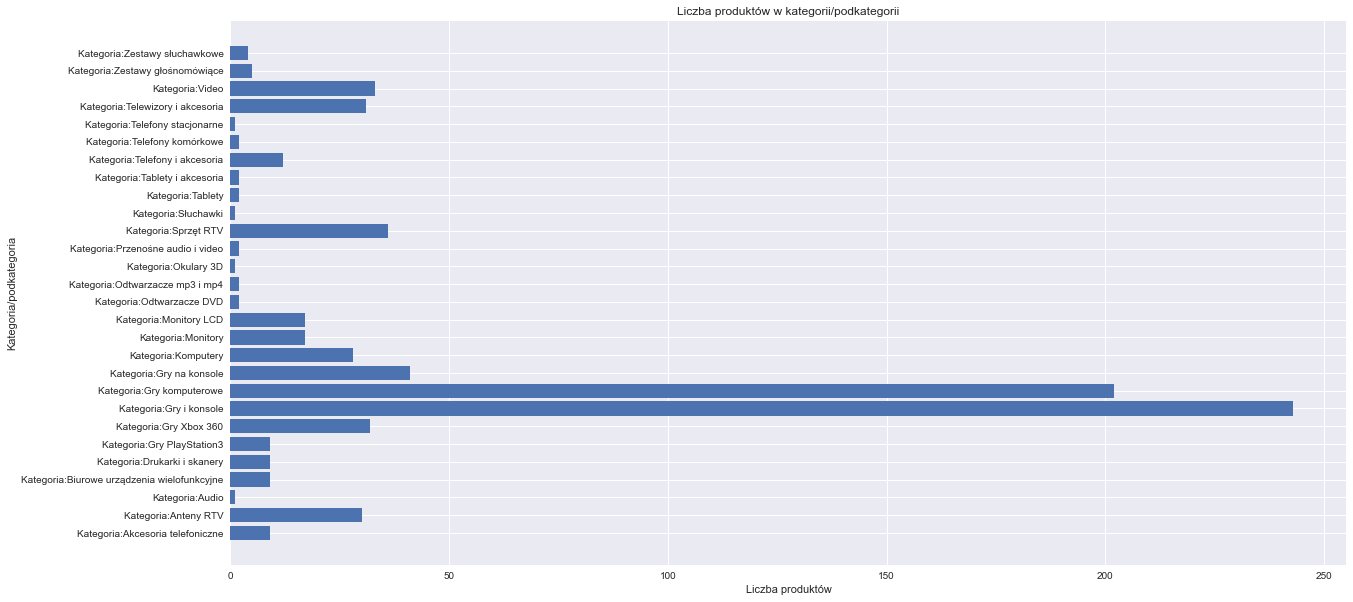

In [23]:
plt.figure(figsize=(20, 10))
plt.barh(list(rows_on_cat.keys()), [len(rows_on_cat[key]) for key in rows_on_cat.keys()])
plt.title('Liczba produktów w kategorii/podkategorii')
plt.xlabel('Liczba produktów')
plt.ylabel('Kategoria/podkategoria')
plt.show()

In [24]:
new_concatenated = pd.concat([df_products, df_products_categorical], axis=1)

In [25]:
new_concatenated.head()

,product_id,product_name,category_path,price,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Słuchawki,Kategoria:Tablety,Kategoria:Tablety i akcesoria,Kategoria:Telefony i akcesoria,Kategoria:Telefony komórkowe,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Statystyka średniej ceny produktów w ramach wszystkich kategorii/podkategorii:

In [26]:
rows_on_cat = {column_name: new_concatenated.loc[new_concatenated[column_name] == 1] for column_name in df_products_categorical.columns}

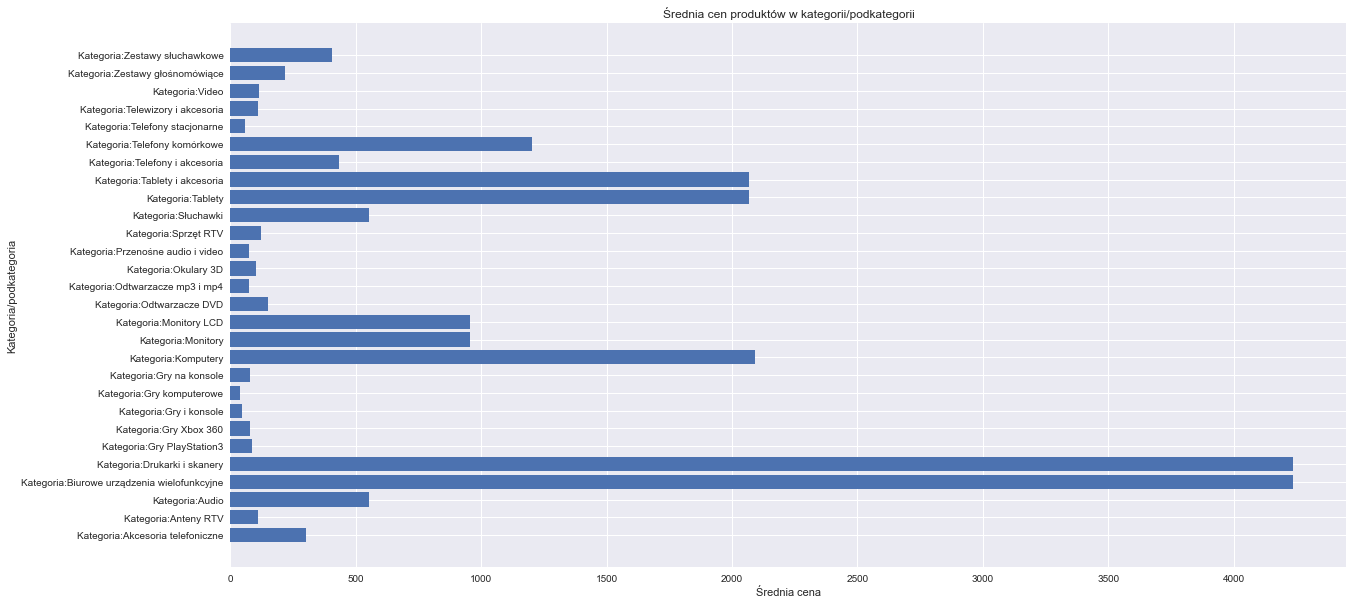

In [27]:
plt.figure(figsize=(20,10))
plt.barh(list(df_products_categorical.keys()), [rows_on_cat[name]['price'].mean() for name in rows_on_cat.keys()])
plt.title('Średnia cen produktów w kategorii/podkategorii')
plt.xlabel('Średnia cena')
plt.ylabel('Kategoria/podkategoria')
plt.show()

Sprawdzenie czy nie ma danych odstających:

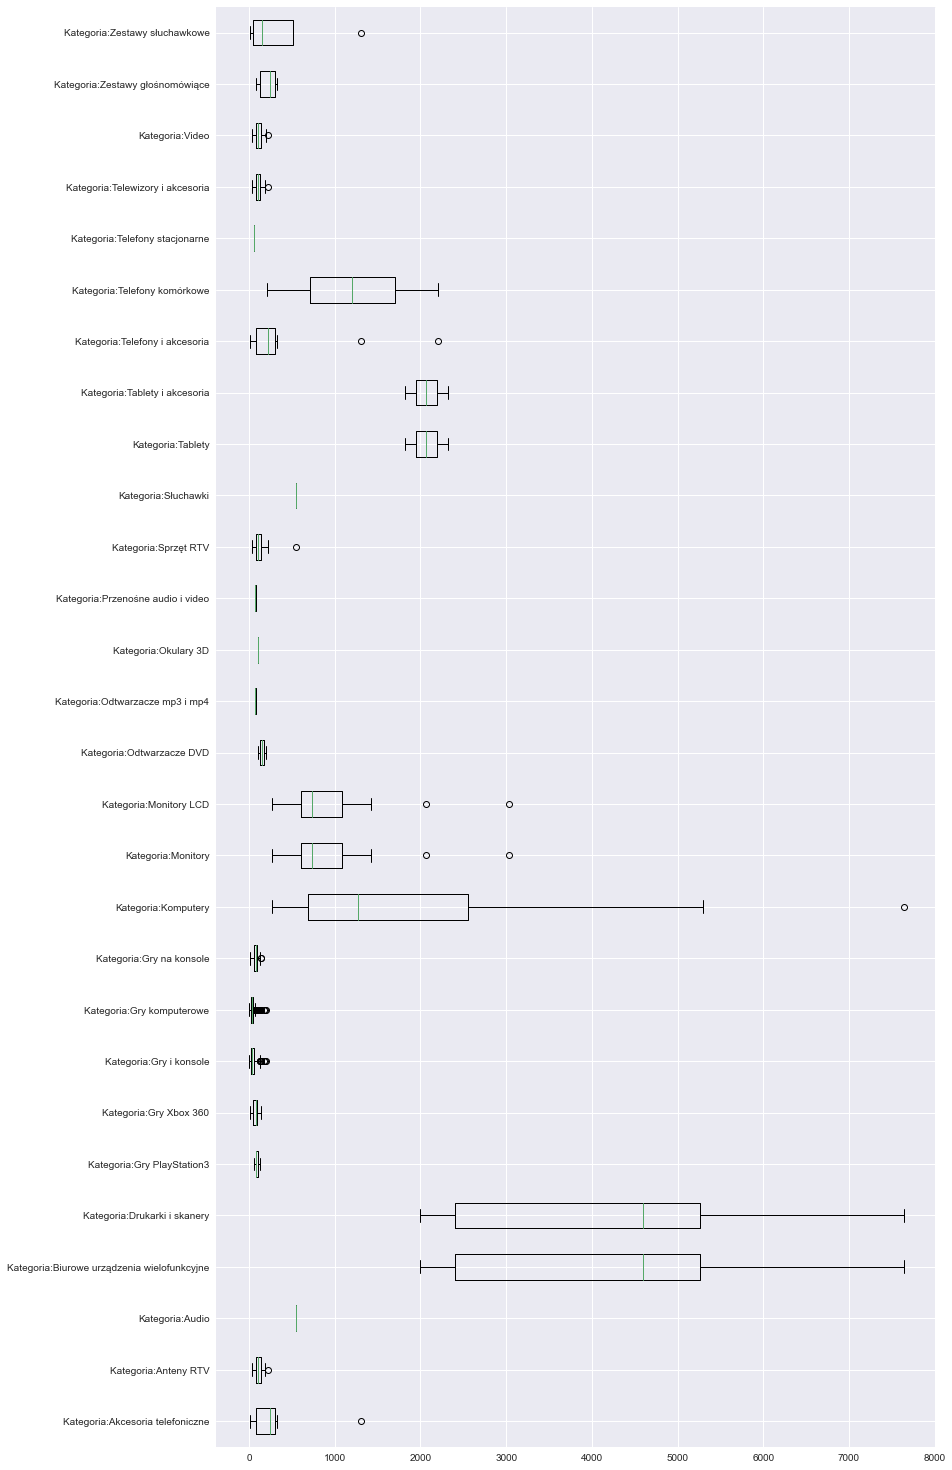

In [28]:
x = []
for category_name in rows_on_cat.keys():
    x.append(rows_on_cat[category_name]['price'])

fig_box = plt.figure(figsize =(10, 20))
ax = fig_box.add_axes([0, 0, 1, 1])
bp = ax.boxplot(x, vert=False, labels = list(df_products_categorical.keys()))
plt.show()

Można zauważyć, że pod względem kategorii nie ma odstających wartości cen.

## I.4. Zależność stanu zakończenia sesji od pory dnia

Agregacja sesji pod względem zakończenia, wydzielenie znacznika czasu pod względem czasu jaki upłynął w ramach sesji oraz jej początku i końca:

In [29]:
agg_func_sess_prod = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'offered_discount' : 'first',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0
}
agg_sess_prod_df = df_sessions.groupby(df_sessions['session_id']).aggregate(agg_func_sess_prod)
agg_sess_prod_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [30]:
timestamp_dict = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in agg_sess_prod_df['timestamp']]
timestamp_df = pd.DataFrame(timestamp_dict)
agg_sess_prod_df = pd.concat([agg_sess_prod_df, timestamp_df], axis=1, join="inner")
agg_sess_prod_df.drop(columns=['timestamp'], inplace=True)
agg_sess_prod_df.index.name = 'session_id'

In [31]:
agg_sess_prod_df.head()

,user_id,product_id,offered_discount,purchased,session_length,session_start,session_end
session_id,,,,,,,
124,102,[1283],5,1,725,2021-08-26 22:27:52,2021-08-26 22:39:57
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,1547,2021-03-08 08:14:24,2021-03-08 08:40:11
126,102,"[1281, 1278]",15,1,347,2021-02-16 17:40:31,2021-02-16 17:46:18
127,102,"[1278, 1281]",0,1,457,2021-03-13 06:48:13,2021-03-13 06:55:50
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,1010,2021-04-18 21:02:01,2021-04-18 21:18:51


Do tej analizy kolumna 'user_id' sie nie przyda:

In [32]:
agg_sess_prod_df.drop(columns=['user_id'], inplace=True)

Podział na pory dnia:
+ 23-7 - noc
+ 7-15 - dzien
+ 15-23 popoludnie

In [33]:
day_period = []
for session_time in agg_sess_prod_df['session_start']:
    if 7 < session_time.hour <= 15:
        day_period.append('dzien')
    elif 15 < session_time.hour <=23:
        day_period.append('popoludnie')
    else:
        day_period.append('noc')

In [34]:
agg_sess_prod_df['day_period'] = day_period

In [35]:
agg_buys = agg_sess_prod_df.loc[agg_sess_prod_df['purchased']==1]
agg_no_buys = agg_sess_prod_df.loc[agg_sess_prod_df['purchased']==0]

Liczba sesji zakończonych/niezakończonych zakupem w zalezności od pory dnia:

<AxesSubplot:>

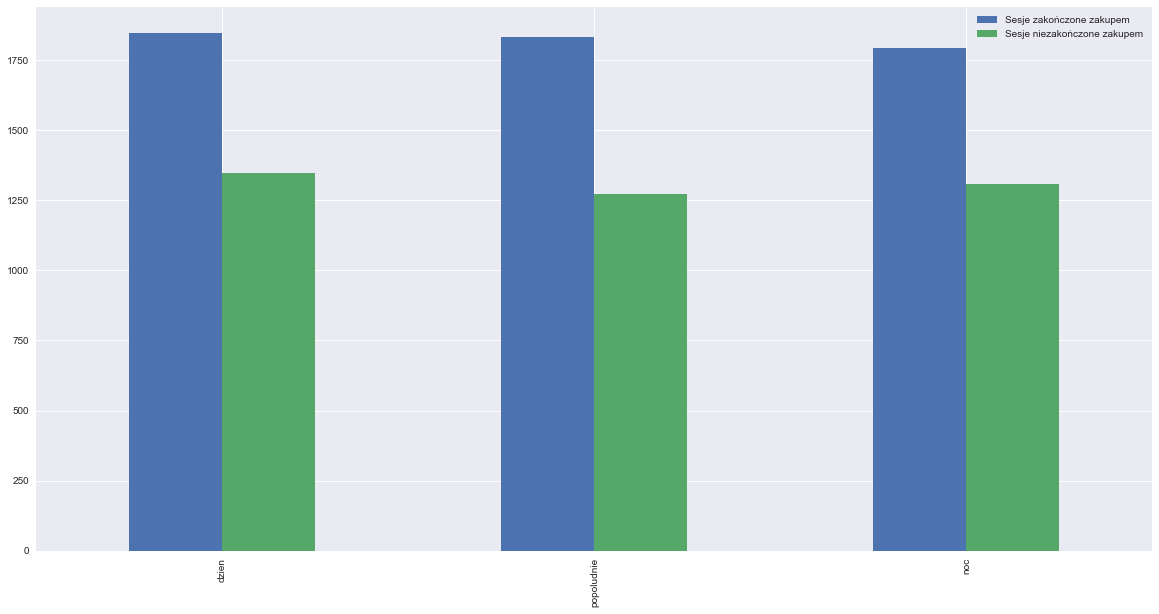

In [36]:
pd.concat([agg_buys['day_period'].value_counts().rename('Sesje zakończone zakupem'), agg_no_buys['day_period'].value_counts().rename('Sesje niezakończone zakupem')], axis=1).plot.bar(figsize=(20,10))

## I.5. Zależności
### Stosunek proponowanych zniżek w procentach do zakupień produktów:

<AxesSubplot:>

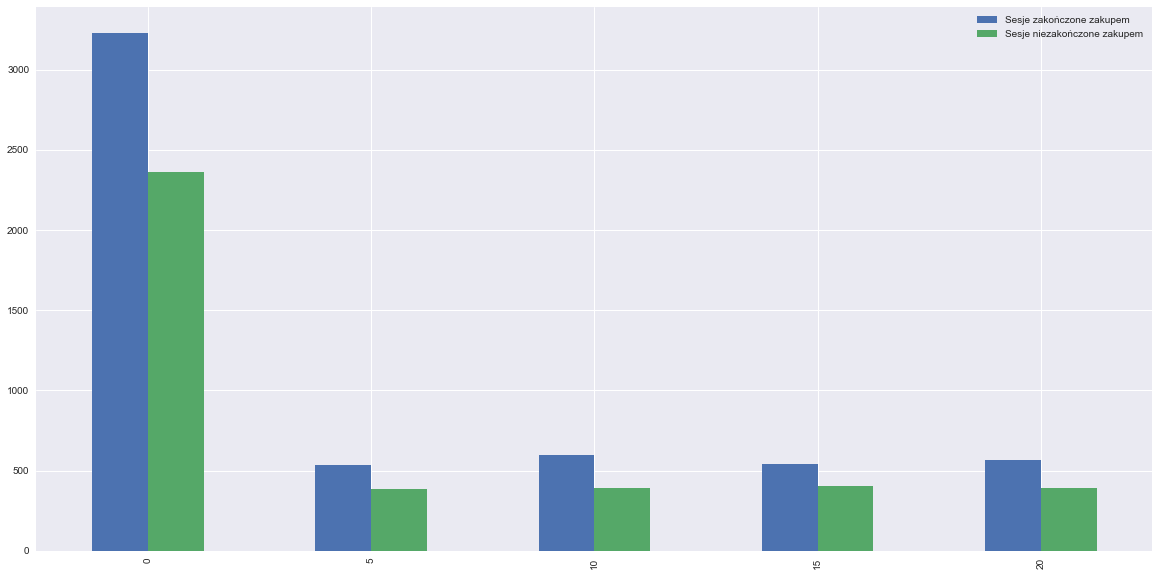

In [37]:
pd.concat([agg_buys['offered_discount'].value_counts().rename('Sesje zakończone zakupem'), agg_no_buys['offered_discount'].value_counts().rename('Sesje niezakończone zakupem')], axis=1).plot.bar(figsize=(20,10))

### Stosunek kategorii produktów do stanu zakończenia sesji:
Scalenie tabeli z sesjami wraz z kategoriami produktów:

In [38]:
df_merged = df_sessions.merge(new_concatenated, left_on='product_id', right_on='product_id')
df_merged.drop(columns=['product_name', 'category_path'], inplace=True)
df_merged.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,price,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,...,Kategoria:Słuchawki,Kategoria:Tablety,Kategoria:Tablety i akcesoria,Kategoria:Telefony i akcesoria,Kategoria:Telefony komórkowe,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,99.99,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,99.99,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,139,2021-07-01 11:28:02,102,1283,VIEW_PRODUCT,0,99.99,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,139,2021-07-01 11:31:18,102,1283,BUY_PRODUCT,0,99.99,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,144,2021-03-19 13:55:04,102,1283,VIEW_PRODUCT,0,99.99,0,0,0,...,0,0,0,0,0,0,1,1,0,0


Agregacja w ramach pojedynczej sesji:

In [39]:
agg_cat_sess_prod = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'offered_discount' : 'first',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'price' : lambda t: [t.sum(), t.mean()]
}

for name in df_products_categorical.columns:
    agg_cat_sess_prod[name] = lambda n: n.sum()

agg_merged_df =df_merged.groupby(df_merged['session_id']).aggregate(agg_cat_sess_prod)
agg_merged_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [40]:
agg_merged_df.head()

,timestamp,user_id,product_id,offered_discount,purchased,price,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,...,Kategoria:Słuchawki,Kategoria:Tablety,Kategoria:Tablety i akcesoria,Kategoria:Telefony i akcesoria,Kategoria:Telefony komórkowe,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe
session_id,,,,,,,,,,,,,,,,,,,,,
124,"[19, 2021-07-28 15:47:21, 2021-07-28 15:47:40]",102,[1283],5,1,"[199.98, 99.99]",0,0,0,0,...,0,0,0,0,0,0,2,2,0,0
125,"[1436, 2021-09-12 16:43:16, 2021-09-12 17:07:12]",102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,"[36664.54, 4073.837777777778]",0,0,0,9,...,0,0,0,0,0,0,0,0,0,0
126,"[117, 2021-04-09 22:31:08, 2021-04-09 22:33:05]",102,"[1281, 1278]",15,1,"[222.6, 74.2]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,"[519, 2021-08-15 16:46:06, 2021-08-15 16:54:45]",102,"[1281, 1278]",0,1,"[208.5, 69.5]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,"[847, 2021-01-05 00:05:38, 2021-01-05 00:19:45]",102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,"[568.94, 81.27714285714286]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Wydzielenie znacznika czasowego:

In [41]:
timestamp_dict_2 = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in agg_merged_df['timestamp']]
timestamp_df_2 = pd.DataFrame(timestamp_dict)
agg_merged_df = pd.concat([agg_merged_df, timestamp_df_2], axis=1, join="inner")
agg_merged_df.drop(columns=['timestamp'], inplace=True)
agg_merged_df.head()

,user_id,product_id,offered_discount,purchased,price,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,...,Kategoria:Telefony i akcesoria,Kategoria:Telefony komórkowe,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end
124,102,[1283],5,1,"[199.98, 99.99]",0,0,0,0,0,...,0,0,0,2,2,0,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,"[36664.54, 4073.837777777778]",0,0,0,9,9,...,0,0,0,0,0,0,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11
126,102,"[1281, 1278]",15,1,"[222.6, 74.2]",0,0,0,0,0,...,0,0,0,0,0,0,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18
127,102,"[1281, 1278]",0,1,"[208.5, 69.5]",0,0,0,0,0,...,0,0,0,0,0,0,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,"[568.94, 81.27714285714286]",0,0,0,0,0,...,0,0,0,0,0,0,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51


Wydzielenie sumy i średniej z ceny produktów przeglądanych:

In [42]:
price_dict = [{'sum_price' : x[0], 'price_mean' : x[1]} for x in agg_merged_df['price']]
price_df = pd.DataFrame(price_dict)
agg_merged_df.reset_index(inplace=True)
agg_merged_df = pd.concat([agg_merged_df, price_df], axis=1, join='inner')
agg_merged_df.drop(columns=['price', 'index'], inplace=True)

In [43]:
agg_merged_df.head()

,user_id,product_id,offered_discount,purchased,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end,sum_price,price_mean
0,102,[1283],5,1,0,0,0,0,0,0,...,0,2,2,0,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57,199.98,99.990000
1,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,0,0,0,9,9,0,...,0,0,0,0,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,36664.54,4073.837778
2,102,"[1281, 1278]",15,1,0,0,0,0,0,0,...,0,0,0,0,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18,222.60,74.200000
3,102,"[1281, 1278]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,208.50,69.500000
4,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,568.94,81.277143


Podział na sesje zakończone sukcesem i zakończone porażką:

In [44]:
# division of aggregate data on sessions with success and without success
agg_merged_buys = agg_merged_df.loc[agg_merged_df['purchased']==1]
agg_merged_no_buys = agg_merged_df.loc[agg_merged_df['purchased']==0]

# division of sets on categories
agg_merged_buys_on_cat = {column_name: agg_merged_buys.loc[agg_merged_buys[column_name] >= 1] for column_name in df_products_categorical.columns}
agg_merged_no_buys_on_cat = {column_name: agg_merged_no_buys.loc[agg_merged_no_buys[column_name] >= 1] for column_name in df_products_categorical.columns}

Zależność liczby sesji zakończonych/nie zakończonych zakupem od kategorii produktów, które są oglądane w danym sklepie:

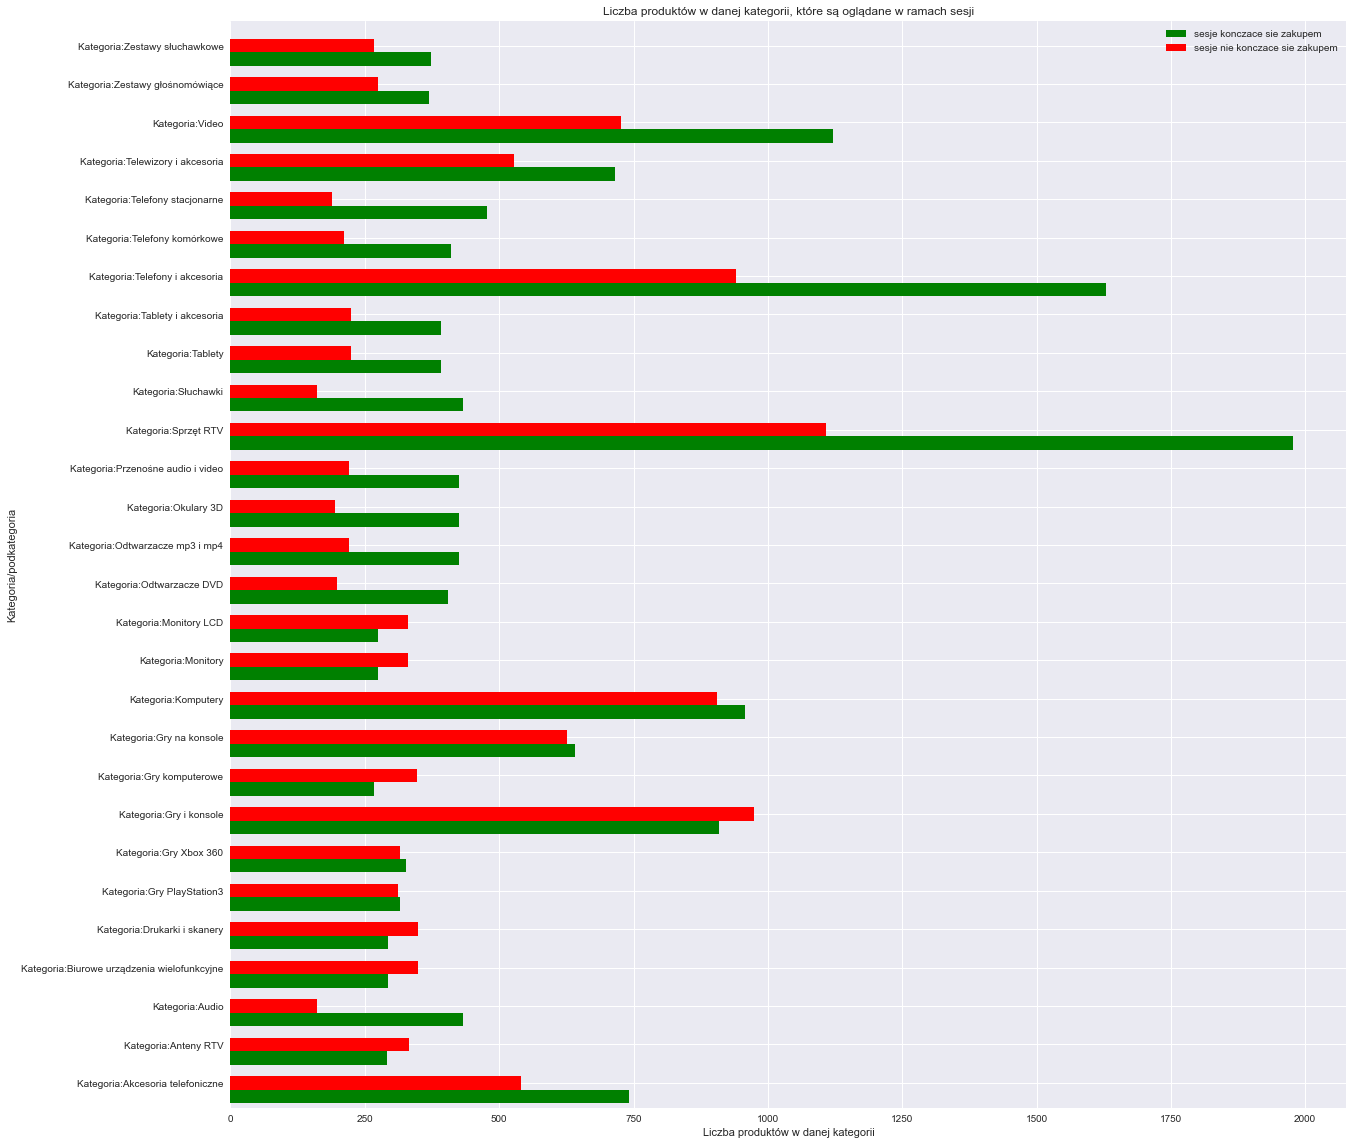

In [45]:
fig, ax = plt.subplots(figsize=(20, 20))

ind = np.arange(len(list(agg_merged_buys_on_cat.keys())))

width = 0.35
ax.barh(ind, [len(agg_merged_buys_on_cat[key]) for key in agg_merged_buys_on_cat.keys()], width, color='green', label='sesje konczace sie zakupem')
ax.barh(ind+width, [len(agg_merged_no_buys_on_cat[key]) for key in agg_merged_buys_on_cat.keys()], width, color='red', label='sesje nie konczace sie zakupem')
ax.set(yticks=ind + width, yticklabels=list(agg_merged_buys_on_cat.keys()), ylim=[2*width -1, len(list(agg_merged_buys_on_cat.keys()))])
ax.legend()
plt.title('Liczba produktów w danej kategorii, które są oglądane w ramach sesji')
plt.xlabel('Liczba produktów w danej kategorii')
plt.ylabel('Kategoria/podkategoria')
plt.show()

Można zauważyć, że stosunek sesji zakończonych zakupem do sesji niezakończonych zakupem jest różny w zależności od kategorii produktów przeglądanych w ramach sesji.

### Zależność kupna w sesji od sumy i sredniej ceny przegladanych zakupow.

In [46]:
agg_merged_df[['sum_price', 'price_mean']].describe()

,sum_price,price_mean
count,9403.000000,9403.000000
mean,2782.690768,694.511215
std,6538.559380,1170.032395
min,14.990000,14.990000
25%,199.980000,78.900000
50%,539.870000,129.990000
75%,1816.970000,639.000000
max,45785.540000,7639.000000


Podział na przedziały:

In [47]:
bins_sum = [0, 100, 200, 300, 400, 500, 600, 800, 1000, 1300, 1600, 1900, 2500, 5000, 10000, 15000, 25000, 40000, 100000]
bins_mean = [0, 20, 40, 70, 100, 115, 140, 200, 300, 500, 800, 1500, 2500, 4000, 7000, 10000]

agg_merged_sum = pd.cut(agg_merged_df['sum_price'], bins=bins_sum, right=True)

agg_merged_mean = pd.cut(agg_merged_df['price_mean'], bins=bins_mean, right=True)

agg_merged_df_bins = agg_merged_df.copy()
agg_merged_df_bins['sum_price'] = agg_merged_sum
agg_merged_df_bins['price_mean'] = agg_merged_mean
agg_merged_df_bins.head()

,user_id,product_id,offered_discount,purchased,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end,sum_price,price_mean
0,102,[1283],5,1,0,0,0,0,0,0,...,0,2,2,0,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57,"(100, 200]","(70, 100]"
1,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,0,0,0,9,9,0,...,0,0,0,0,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,"(25000, 40000]","(4000, 7000]"
2,102,"[1281, 1278]",15,1,0,0,0,0,0,0,...,0,0,0,0,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18,"(200, 300]","(70, 100]"
3,102,"[1281, 1278]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,"(200, 300]","(40, 70]"
4,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,"(500, 600]","(70, 100]"


Podział na zbiory zakup/brak zakupu:

In [48]:
agg_merged_buys_bins = agg_merged_df_bins.loc[agg_merged_df_bins['purchased']==1]
agg_merged_no_buys_bins = agg_merged_df_bins.loc[agg_merged_df_bins['purchased']==0]

Funkcja plotująca różnice:

In [49]:
def plot_buys_nobuys_diff(buys_df, nobuys_df, merged_df, column_name, title, xlabel, ylabel, width = 0.35, figsize=(20, 20)):
    fig_diff, ax = plt.subplots(figsize=figsize)
    indexes = np.arange(len(list(merged_df[column_name].value_counts().keys())))
    ax.barh(indexes, buys_df[column_name].value_counts().sort_index(), width, color='green', label='sesje konczace sie zakupem')
    ax.barh(indexes+width, nobuys_df[column_name].value_counts().sort_index(), width, color='red', label='sesje nie konczace sie zakupem')
    ax.set(yticks=indexes + width, yticklabels=list(merged_df[column_name].value_counts().sort_index().keys()), ylim=[2*width -1, len(list(merged_df[column_name].value_counts().sort_index().keys()))])
    ax.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Zależność liczby sesji zakończonych zakupem/jego brakiem od łącznej ceny przeglądanych produktów:

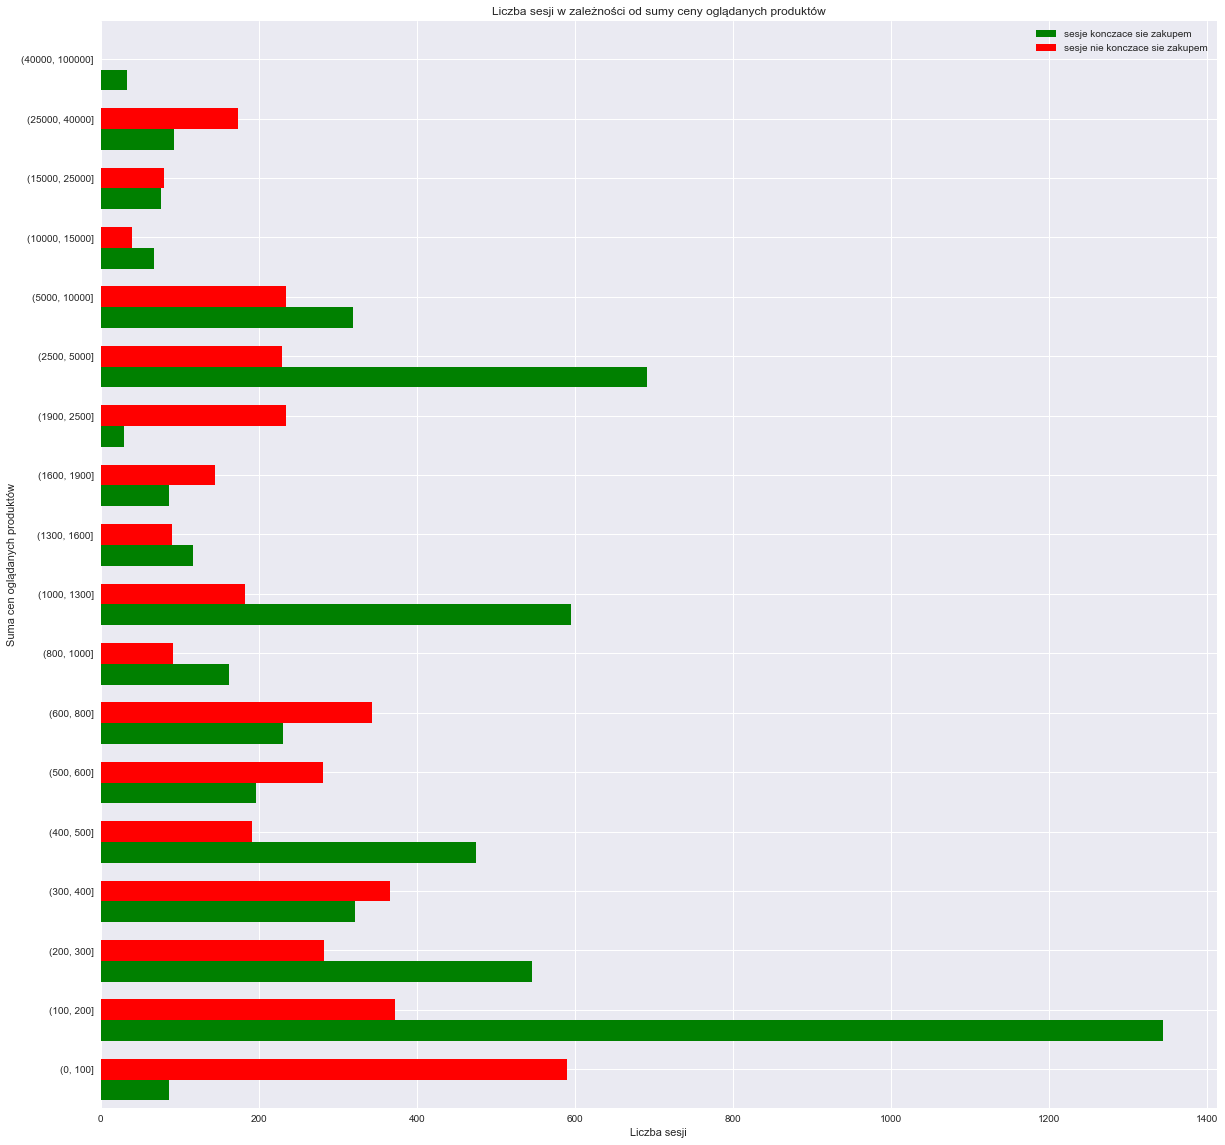

In [50]:
plot_buys_nobuys_diff(buys_df=agg_merged_buys_bins, nobuys_df=agg_merged_no_buys_bins, merged_df=agg_merged_df_bins, column_name='sum_price', title='Liczba sesji w zależności od sumy ceny oglądanych produktów', xlabel='Liczba sesji', ylabel='Suma cen oglądanych produktów')

Zależność liczby sesji zakończonych zakupem/jego brakiem od średniej ceny przeglądanych produktów:

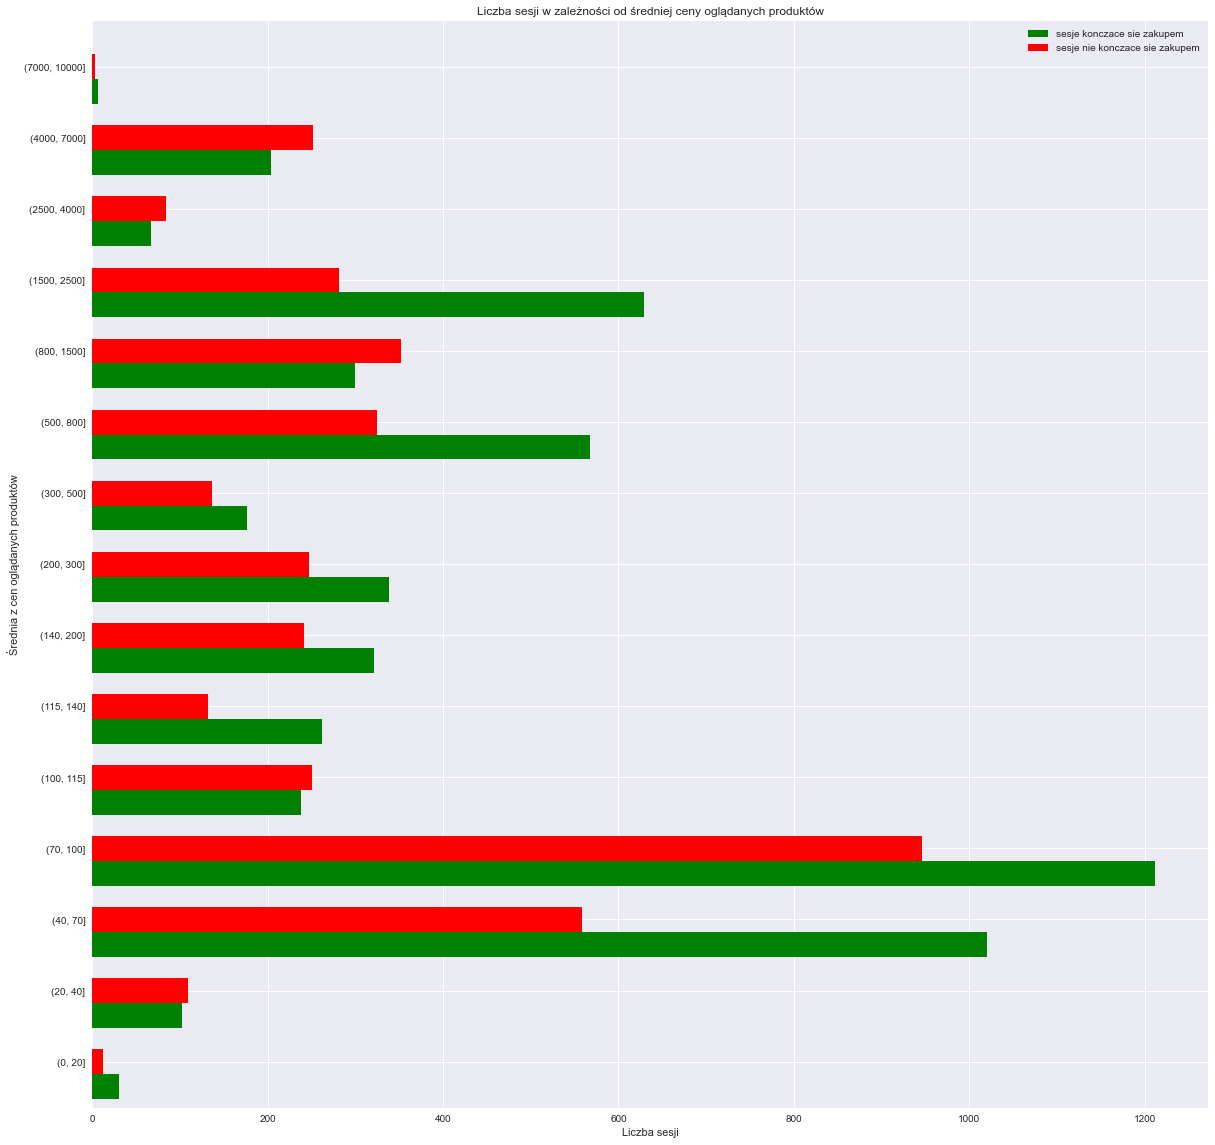

In [51]:
plot_buys_nobuys_diff(buys_df=agg_merged_buys_bins, nobuys_df=agg_merged_no_buys_bins, merged_df=agg_merged_df_bins, column_name='price_mean', title='Liczba sesji w zależności od średniej ceny oglądanych produktów', xlabel='Liczba sesji', ylabel='Średnia z cen oglądanych produktów')

### Zależność kupna w sesji od sumy i sredniej ceny zniżki (w kwocie)
Przygotowanie kolumn:

In [52]:
agg_merged_df.head()

,user_id,product_id,offered_discount,purchased,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Telefony stacjonarne,Kategoria:Telewizory i akcesoria,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end,sum_price,price_mean
0,102,[1283],5,1,0,0,0,0,0,0,...,0,2,2,0,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57,199.98,99.990000
1,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,0,0,0,9,9,0,...,0,0,0,0,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,36664.54,4073.837778
2,102,"[1281, 1278]",15,1,0,0,0,0,0,0,...,0,0,0,0,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18,222.60,74.200000
3,102,"[1281, 1278]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,208.50,69.500000
4,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,568.94,81.277143


In [53]:
sum_discount = []
mean_discount = []
for discout, sum_price, mean_price in zip(agg_merged_df['offered_discount'], agg_merged_df['sum_price'], agg_merged_df['price_mean']):
    sum_discount.append(round(discout/100 * sum_price,2))
    mean_discount.append(round(discout/100 * mean_price,2))

In [54]:
agg_merged_discounts = copy(agg_merged_df)
agg_merged_discounts['sum_discount'] = sum_discount
agg_merged_discounts['mean_discount'] = mean_discount

In [55]:
agg_merged_discounts.head()

,user_id,product_id,offered_discount,purchased,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Video,Kategoria:Zestawy głośnomówiące,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end,sum_price,price_mean,sum_discount,mean_discount
0,102,[1283],5,1,0,0,0,0,0,0,...,2,0,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57,199.98,99.990000,10.00,5.00
1,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,0,0,0,9,9,0,...,0,0,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,36664.54,4073.837778,0.00,0.00
2,102,"[1281, 1278]",15,1,0,0,0,0,0,0,...,0,0,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18,222.60,74.200000,33.39,11.13
3,102,"[1281, 1278]",0,1,0,0,0,0,0,0,...,0,0,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,208.50,69.500000,0.00,0.00
4,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,0,0,0,0,0,0,...,0,0,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,568.94,81.277143,0.00,0.00


Podział na zakresy:

In [56]:
agg_merged_discounts[['sum_discount', 'mean_discount']].describe()

,sum_discount,mean_discount
count,9403.000000,9403.000000
mean,141.631848,35.002403
std,600.387820,112.033994
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,38.925000,11.915000
max,8689.690000,1204.460000


In [57]:
bins_disc_sum = [-1, 10, 20, 35, 50, 100, 130, 180, 300, 600, 1300, 2000, 4000, 6000, 8000, 10000]
bins_disc_mean = [-1, 5, 10, 15, 20, 25, 30, 35, 50, 80, 150, 300, 500, 800, 1050, 1300]

agg_merged_disc_sum = pd.cut(agg_merged_discounts['sum_discount'], bins=bins_disc_sum, right=True)

agg_merged_disc_mean = pd.cut(agg_merged_discounts['mean_discount'], bins=bins_disc_mean, right=True)

agg_merged_disc_bins = copy(agg_merged_discounts)
agg_merged_disc_bins['sum_discount_bin'] = agg_merged_disc_sum
agg_merged_disc_bins['mean_discount_bin'] = agg_merged_disc_mean

In [58]:
agg_merged_disc_bins

,user_id,product_id,offered_discount,purchased,Kategoria:Akcesoria telefoniczne,Kategoria:Anteny RTV,Kategoria:Audio,Kategoria:Biurowe urządzenia wielofunkcyjne,Kategoria:Drukarki i skanery,Kategoria:Gry PlayStation3,...,Kategoria:Zestawy słuchawkowe,session_length,session_start,session_end,sum_price,price_mean,sum_discount,mean_discount,sum_discount_bin,mean_discount_bin
0,102,[1283],5,1,0,0,0,0,0,0,...,0,725,2021-08-26 22:27:52,2021-08-26 22:39:57,199.98,99.990000,10.00,5.00,"(-1, 10]","(-1, 5]"
1,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1,0,0,0,9,9,0,...,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,36664.54,4073.837778,0.00,0.00,"(-1, 10]","(-1, 5]"
2,102,"[1281, 1278]",15,1,0,0,0,0,0,0,...,0,347,2021-02-16 17:40:31,2021-02-16 17:46:18,222.60,74.200000,33.39,11.13,"(20, 35]","(10, 15]"
3,102,"[1281, 1278]",0,1,0,0,0,0,0,0,...,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,208.50,69.500000,0.00,0.00,"(-1, 10]","(-1, 5]"
4,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1,0,0,0,0,0,0,...,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,568.94,81.277143,0.00,0.00,"(-1, 10]","(-1, 5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9398,300,"[1319, 1315, 1317]",5,1,4,0,0,0,0,0,...,4,0,2021-01-27 03:30:15,2021-01-27 03:30:15,2677.90,669.475000,133.90,33.47,"(130, 180]","(30, 35]"
9399,300,"[1076, 1080, 1079, 1002, 1075, 1078, 1081]",0,1,0,0,0,8,8,0,...,0,116,2021-07-06 16:22:43,2021-07-06 16:24:39,31328.54,3916.067500,0.00,0.00,"(-1, 10]","(-1, 5]"
9400,300,"[1290, 1293, 1287, 1288, 1285, 1291, 1289, 128...",5,1,0,10,0,0,0,0,...,0,1617,2021-03-07 07:27:50,2021-03-07 07:54:47,1121.66,112.166000,56.08,5.61,"(50, 100]","(5, 10]"
9401,300,"[1079, 1002, 1078, 1081]",0,0,0,0,0,4,4,0,...,0,0,2021-10-12 00:19:45,2021-10-12 00:19:45,17031.50,4257.875000,0.00,0.00,"(-1, 10]","(-1, 5]"


In [59]:
agg_merged_buys_disc_bins = agg_merged_disc_bins.loc[agg_merged_disc_bins['purchased']==1]
agg_merged_no_buys_disc_bins = agg_merged_disc_bins.loc[agg_merged_disc_bins['purchased']==0]

Stosunek liczby sesji zakończonych/niezakończonych zakupem do sumy ze zniżki w kwocie:

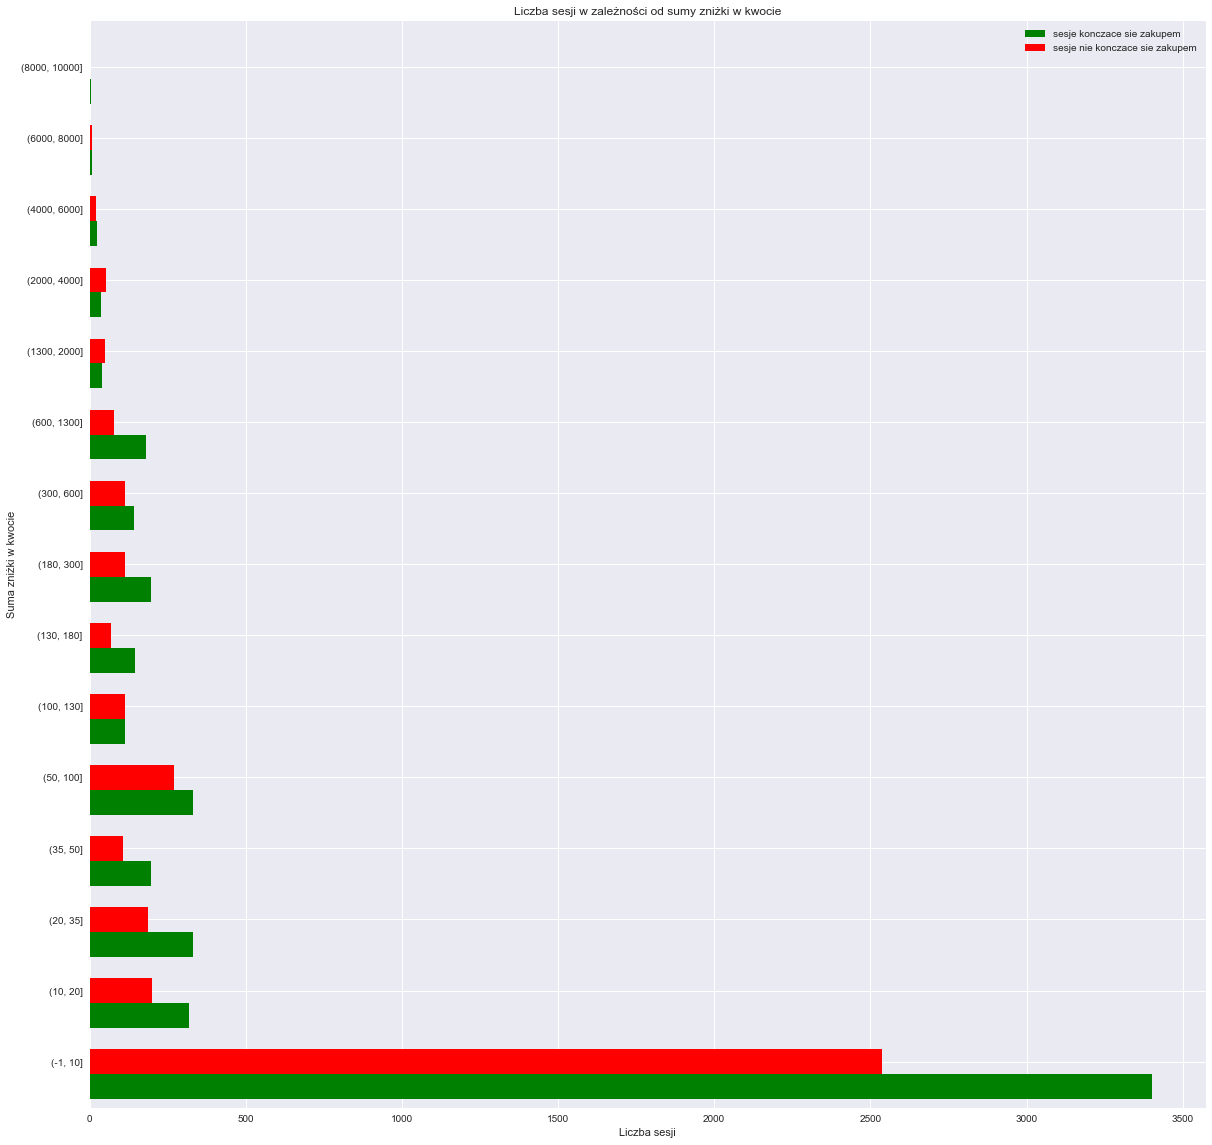

In [60]:
plot_buys_nobuys_diff(buys_df=agg_merged_buys_disc_bins, nobuys_df=agg_merged_no_buys_disc_bins, merged_df=agg_merged_disc_bins, column_name='sum_discount_bin', title='Liczba sesji w zależności od sumy zniżki w kwocie', xlabel='Liczba sesji', ylabel='Suma zniżki w kwocie')

Stosunek liczby sesji zakończonych/niezakończonych zakupem do średniej ze zniżki w kwocie:

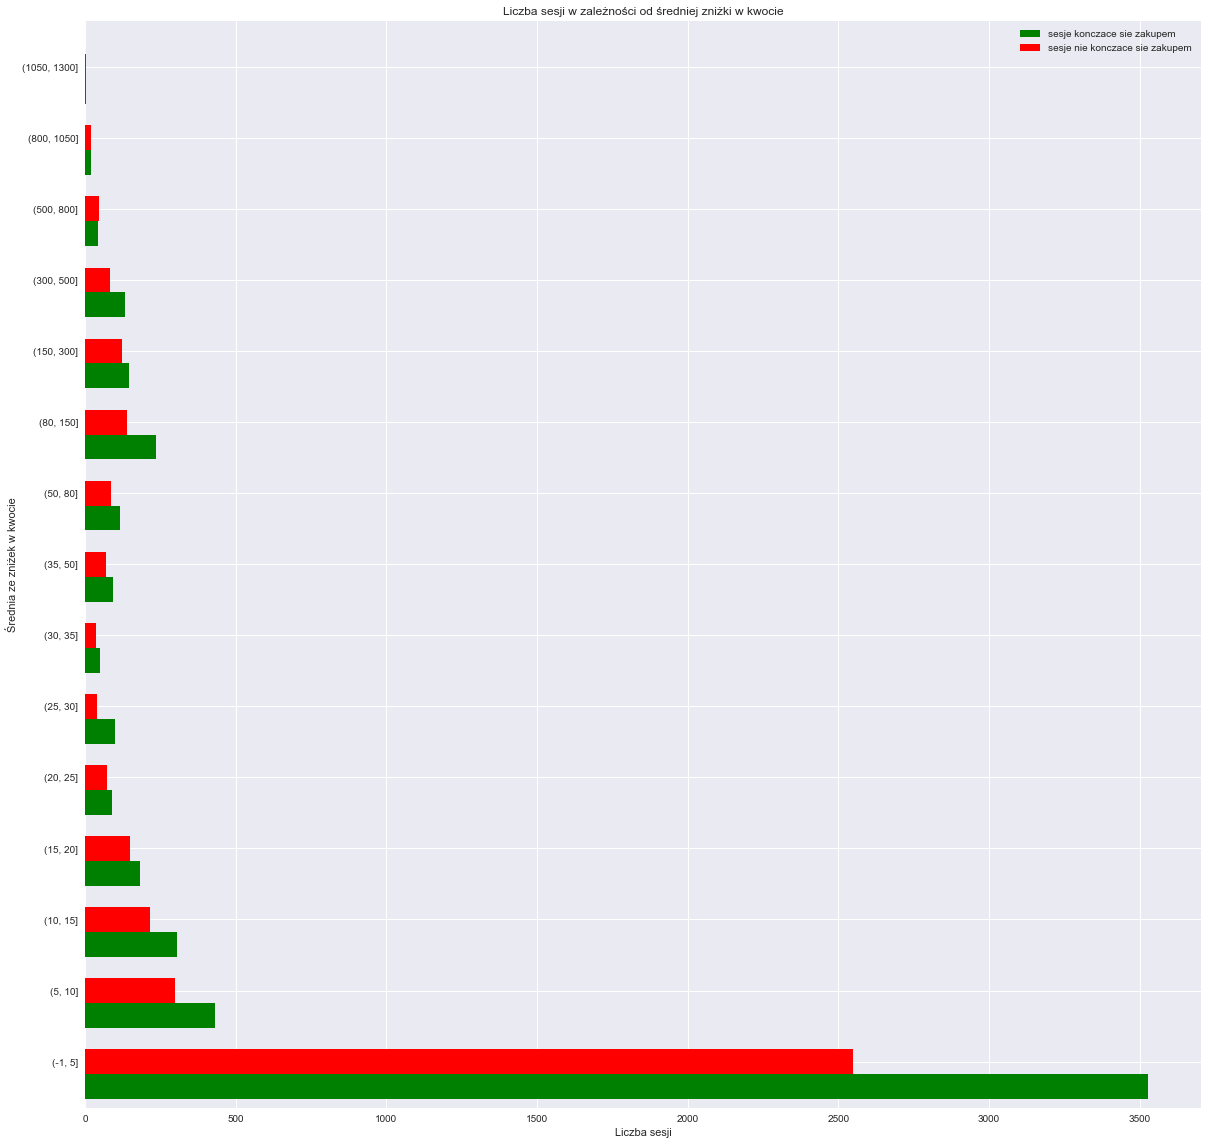

In [61]:
plot_buys_nobuys_diff(buys_df=agg_merged_buys_disc_bins, nobuys_df=agg_merged_no_buys_disc_bins, merged_df=agg_merged_disc_bins, column_name='mean_discount_bin', title='Liczba sesji w zależności od średniej zniżki w kwocie', xlabel='Liczba sesji', ylabel='Średnia ze zniżek w kwocie')

# II. Analiza danych w kontekście użytkowników

In [62]:
plt.rcParams['figure.figsize'] = (10, 6)

In [63]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0


In [64]:
df_users.head()

,user_id,name,city,street
0,102,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Poznań,al. Wrocławska 10
2,104,Radosław Ratka,Szczecin,pl. Nowa 89/04
3,105,Anastazja Oszust,Warszawa,ul. Częstochowska 80
4,106,Sylwia Nurek,Warszawa,al. Wiosenna 72


## II.1. Agregacja informacji o sesjach

Nie bierzemy **purchase_id** pod uwagę, ponieważ nie będziemy mieli tej informacji przed zakończeniem sesji.<br>
- Z kolumny **timestamp** istotny może być początek i koniec sesji, a także czas jej trwania
- **event_type** niesie informację, czy sesja zakończyła się zakupem, czy też nie - będzie to nasza kolumna, której wartość będziemy przewidywać
- tymczasowo przechowujemy w liście wszystkie **product_id** przeglądane w trakcie sesji - długość tej listy - 1 może również nieść informacje o tym, ile było wszystkich wyświetleń przedmiotów w trakcie sesji

In [65]:
aggregation_functions = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'offered_discount' : 'first'
}
agg_sessions_df = df_sessions.groupby(df_sessions['session_id']).aggregate(aggregation_functions)
agg_sessions_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [66]:
agg_sessions_df.head()

,timestamp,user_id,product_id,purchased,offered_discount
session_id,,,,,
124,"[19, 2021-07-28 15:47:21, 2021-07-28 15:47:40]",102,[1283],1,5
125,"[1436, 2021-09-12 16:43:16, 2021-09-12 17:07:12]",102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",1,0
126,"[117, 2021-04-09 22:31:08, 2021-04-09 22:33:05]",102,"[1281, 1278]",1,15
127,"[519, 2021-08-15 16:46:06, 2021-08-15 16:54:45]",102,"[1278, 1281]",1,0
128,"[847, 2021-01-05 00:05:38, 2021-01-05 00:19:45]",102,"[1008, 1007, 1013, 1012, 1004, 1010]",1,0


In [67]:
timestamp_dict = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in agg_sessions_df['timestamp']]

In [68]:
timestamp_df = pd.DataFrame(timestamp_dict)

In [69]:
agg_sessions_df = pd.concat([agg_sessions_df, timestamp_df], axis=1, join="inner")
agg_sessions_df.drop(columns=['timestamp'], inplace=True)
agg_sessions_df.index.name = 'session_id'
agg_sessions_df.head()

,user_id,product_id,purchased,offered_discount,session_length,session_start,session_end
session_id,,,,,,,
124,102,[1283],1,5,725,2021-08-26 22:27:52,2021-08-26 22:39:57
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",1,0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11
126,102,"[1281, 1278]",1,15,347,2021-02-16 17:40:31,2021-02-16 17:46:18
127,102,"[1278, 1281]",1,0,457,2021-03-13 06:48:13,2021-03-13 06:55:50
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",1,0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51


## II.2. Połączenie tabeli sesji i użytkowników

Z tabeli użytkowników istotną informację może nieść miasto w którym mieszka użytkownik - kolumna **city**

In [70]:
df = agg_sessions_df.join(other=df_users.set_index('user_id'), on='user_id')
df.drop(columns=['name', 'street'], inplace=True)

# Zmiana kolejności kolumn, żeby przewidywana kolumna, czyli purchased, była ostanią kolumną
df = df[['user_id', 'product_id', 'offered_discount', 'session_length', 'session_start', 'session_end', 'city', 'purchased']]

In [71]:
df.head()

,user_id,product_id,offered_discount,session_length,session_start,session_end,city,purchased
session_id,,,,,,,,
124,102,[1283],5,725,2021-08-26 22:27:52,2021-08-26 22:39:57,Poznań,1
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,Poznań,1
126,102,"[1281, 1278]",15,347,2021-02-16 17:40:31,2021-02-16 17:46:18,Poznań,1
127,102,"[1278, 1281]",0,457,2021-03-13 06:48:13,2021-03-13 06:55:50,Poznań,1
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,Poznań,1


In [72]:
df.describe()

,user_id,offered_discount,session_length,purchased
count,9403.000000,9403.000000,9403.000000,9403.000000
mean,196.955652,5.092524,407.411996,0.582155
std,58.246122,7.107596,415.401841,0.493231
min,102.000000,0.000000,0.000000,0.000000
25%,147.000000,0.000000,100.000000,0.000000
50%,193.000000,0.000000,259.000000,1.000000
75%,246.000000,10.000000,603.500000,1.000000
max,300.000000,20.000000,2202.000000,1.000000


## II.3. Zbalansowanie zbioru

In [73]:
sessions_with_purchase = df.loc[df['purchased'] == 1]

In [74]:
sessions_without_purchase = df.loc[df['purchased'] == 0]

Text(0, 0.5, 'Liczba sesji')

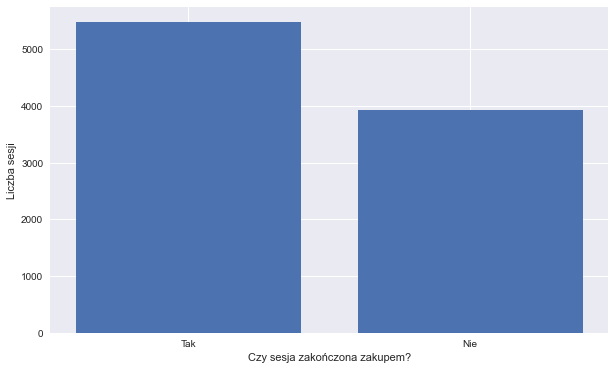

In [75]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase.shape[0], sessions_without_purchase.shape[0]])
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Liczba sesji')

## II.4. Długość trwania sesji

Text(0, 0.5, 'Liczba sesji')

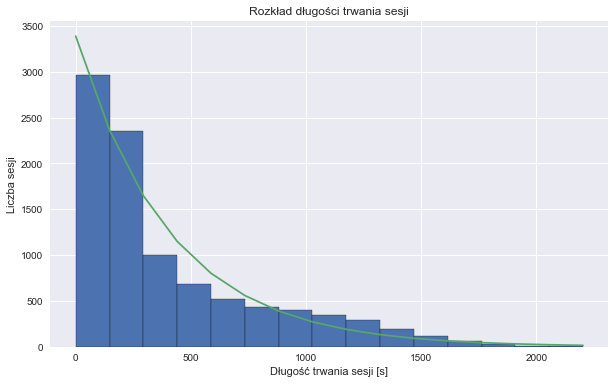

In [76]:
P = ss.expon.fit(df['session_length'])
n, bins, patches = plt.hist(df['session_length'], bins=15, edgecolor='black')
y = ss.expon.pdf(bins, *P) * np.sum(n * np.diff(bins))
plt.plot(bins, y)
plt.title('Rozkład długości trwania sesji')
plt.xlabel('Długość trwania sesji [s]')
plt.ylabel('Liczba sesji')

Text(0, 0.5, 'Liczba sesji')

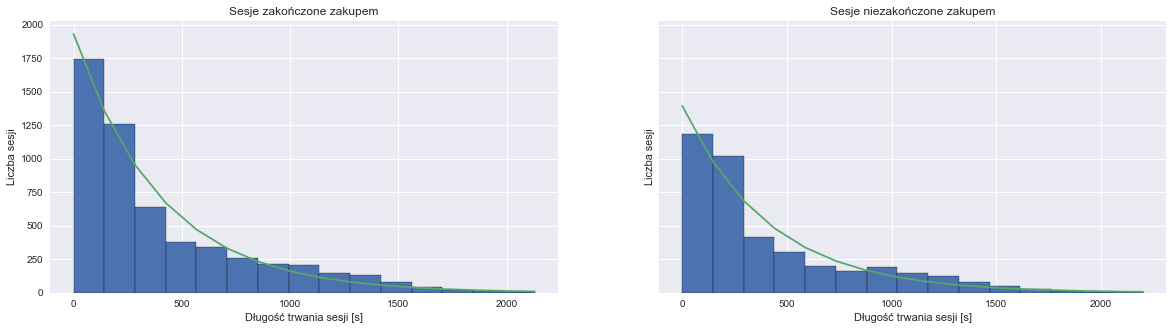

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

n0, bins0, patches0 = ax[0].hist(sessions_with_purchase['session_length'], bins=15, edgecolor='black')
P0 = ss.expon.fit(sessions_with_purchase['session_length'])
y0 = ss.expon.pdf(bins0, *P0) * np.sum(n0 * np.diff(bins0))
ax[0].plot(bins0, y0)
ax[0].set_title('Sesje zakończone zakupem')
ax[0].set_xlabel('Długość trwania sesji [s]')
ax[0].set_ylabel('Liczba sesji')

n1, bins1, patches1 = ax[1].hist(sessions_without_purchase['session_length'], bins=15, edgecolor='black')
P1 = ss.expon.fit(sessions_without_purchase['session_length'])
y1 = ss.expon.pdf(bins1, *P1) * np.sum(n1 * np.diff(bins1))
ax[1].plot(bins1, y1)
ax[1].set_title('Sesje niezakończone zakupem')
ax[1].set_xlabel('Długość trwania sesji [s]')
ax[1].set_ylabel('Liczba sesji')

Text(0, 0.5, 'Średnia długość trwania sesji [s]')

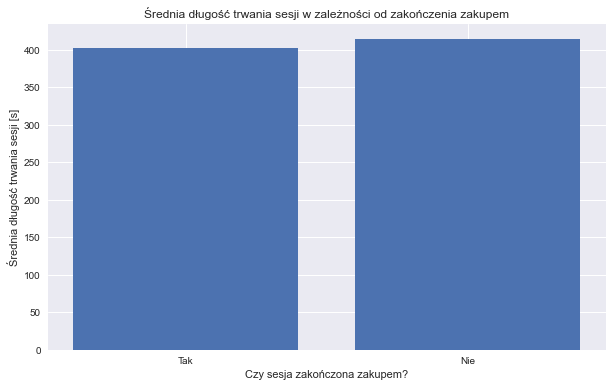

In [78]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase['session_length'].mean(), sessions_without_purchase['session_length'].mean()])
plt.title('Średnia długość trwania sesji w zależności od zakończenia zakupem')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia długość trwania sesji [s]')

## II.5. Sesje niezakończone zakupem bez sesji składających się z pojedynczego wyświetlenia przedmiotu

In [79]:
sessions_without_purchase_and_0 = sessions_without_purchase.loc[sessions_without_purchase['session_length'] != 0]

C:\Users\01149762\AppData\Local\pypoetry\Cache\virtualenvs\session-purchase-mTZHEukO-py3.9\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0, 0.5, 'Liczba sesji')

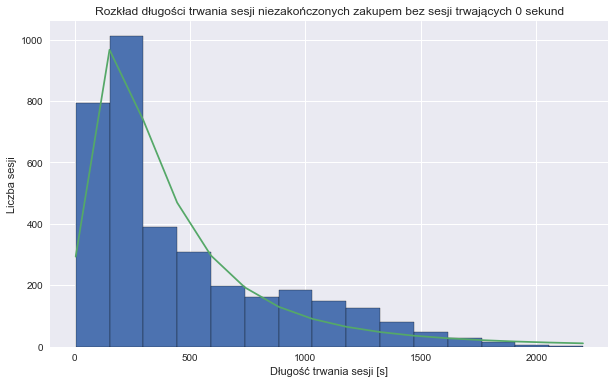

In [80]:
P = ss.invgamma.fit(sessions_without_purchase_and_0['session_length'])
n, bins, patches = plt.hist(sessions_without_purchase_and_0['session_length'], bins=15, edgecolor='black')
y = ss.invgamma.pdf(bins, *P) * np.sum(n * np.diff(bins))
plt.plot(bins, y)
plt.title('Rozkład długości trwania sesji niezakończonych zakupem bez sesji trwających 0 sekund')
plt.xlabel('Długość trwania sesji [s]')
plt.ylabel('Liczba sesji')

Poprzednie długości trwania sesji da się dobrze aproksymować rozkładem wykładniczym. Natomiast po usunięciu sesji trwających 0 lepszy efekt aproksymacji uzyskamy na przykład przy pomocy odwróconego rozkładu Gamma.

Text(0, 0.5, 'Średnia długość trwania sesji [s]')

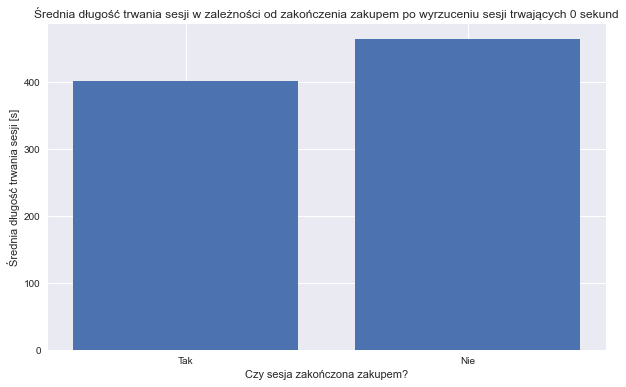

In [81]:
plt.bar(['Tak', 'Nie'], [sessions_with_purchase['session_length'].mean(), sessions_without_purchase_and_0['session_length'].mean()])
plt.title('Średnia długość trwania sesji w zależności od zakończenia zakupem po wyrzuceniu sesji trwających 0 sekund')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia długość trwania sesji [s]')

Wniosek jest taki, że sesje niezakończone zakupem to głównie sesje:
- składające się z pojedynczego wyświetlenia przedmiotu
- trwające dłużej czasu niż sesje zakończone zakupem

Być może sesje składające się z pojedynczego wyświetlenia przedmiotu powinny być wyrzucone ze zbioru danych - mogą to być sesje użytkowników niezainteresowanych szerzej ofertą sklepu w danym momencie, mogli oni być przekierowani na stronę sklepu na przykład za pośrednictwem linka od znajomego.


Sesje niezakończone zakupem przeważnie trwają dłużej niż sesje zakończone zakupem, aczkolwiek średni czas trwania sesji jest podobny, ponieważ istnieją też sesje niezakończone zakupem, które trwają 0 sekund.

## II.6. Długość trwania sesji w poszczególnych miastach

Text(0.5, 1.0, 'Długość trwania sesji w poszczególnych miastach')

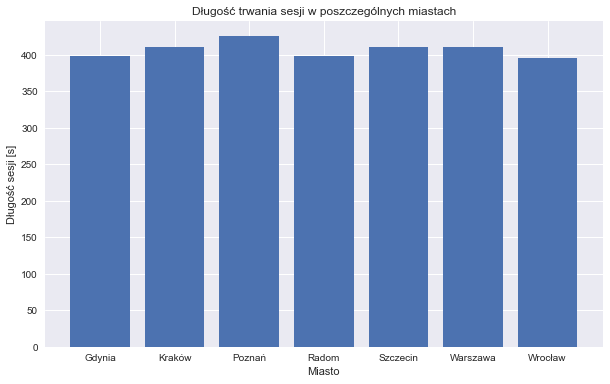

In [82]:
plt.bar(df.groupby(df['city'])['session_length'].agg('mean').keys().values, df.groupby(df['city'])['session_length'].agg('mean').values)
plt.ylabel('Długość sesji [s]')
plt.xlabel('Miasto')
plt.title('Długość trwania sesji w poszczególnych miastach')

Text(0.5, 1.0, 'Sesje niezakończone zakupem')

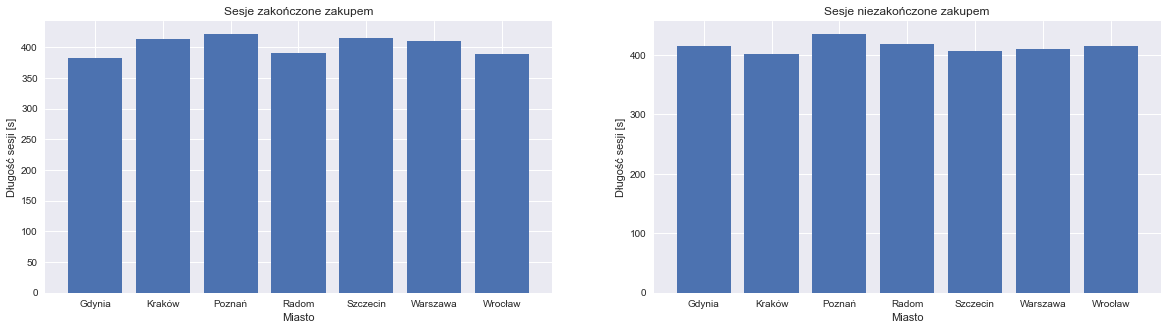

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax[0].bar(sessions_with_purchase.groupby(sessions_with_purchase['city'])['session_length'].agg('mean').keys().values,
          sessions_with_purchase.groupby(sessions_with_purchase['city'])['session_length'].agg('mean').values)
ax[0].set_ylabel('Długość sesji [s]')
ax[0].set_xlabel('Miasto')
ax[0].set_title('Sesje zakończone zakupem')

ax[1].bar(sessions_without_purchase.groupby(sessions_without_purchase['city'])['session_length'].agg('mean').keys().values,
          sessions_without_purchase.groupby(sessions_without_purchase['city'])['session_length'].agg('mean').values)
ax[1].set_ylabel('Długość sesji [s]')
ax[1].set_xlabel('Miasto')
ax[1].set_title('Sesje niezakończone zakupem')

W każdym mieście średnia długość trwania sesji jest podobna.

## II.7. Czas w którym trwały sesje

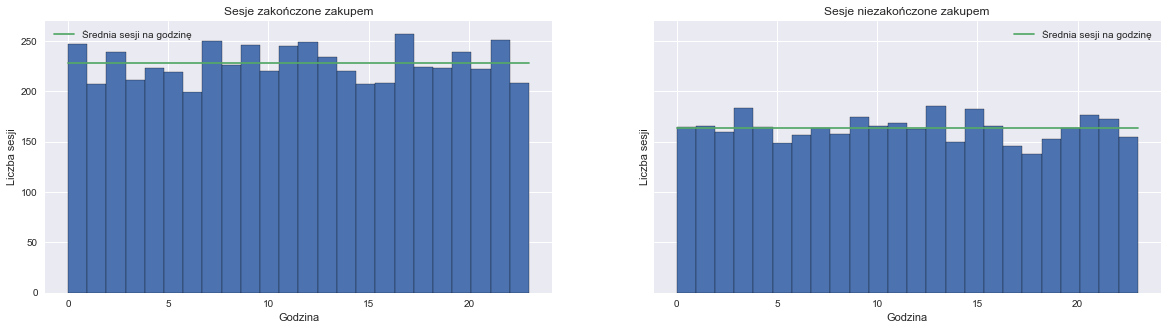

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

ax[0].hist(sessions_with_purchase['session_start'].dt.hour, bins=24, edgecolor='black')
ax[0].plot(np.arange(24), [sessions_with_purchase.shape[0]/24]*24, label='Średnia sesji na godzinę')
ax[0].set_title('Sesje zakończone zakupem')
ax[0].set_xlabel('Godzina')
ax[0].set_ylabel('Liczba sesji')
ax[0].legend()

ax[1].hist(sessions_without_purchase['session_start'].dt.hour, bins=24, edgecolor='black')
ax[1].plot(np.arange(24), [sessions_without_purchase.shape[0]/24]*24, label='Średnia sesji na godzinę')
ax[1].set_title('Sesje niezakończone zakupem')
ax[1].set_xlabel('Godzina')
ax[1].set_ylabel('Liczba sesji')
ax[1].legend()

Liczba sesji nie odbiega znacznie od średniej w żadnym z przypadków, jednak da się zauważyć pewne prawidłowości.<br>
Dla sesji zakończonych zakupem:
- Więcej niż zwykle sesji dokonuje się w godzinach: 24, 7, 17 oraz 22
- Mniej niż zwykle sesji dokonuje się w godzinach: 1, 6, 15, 16 oraz 23

Dla sesji niezkończonych zakupem:
- Więcej niż zwykle sesji dokonuje się w godzinach: 3, 13 oraz 15
- Mniej niż zwykle sesji dokonuje się w godzinach: 5, 14, 17 oraz 18

## II.8. Miasta zamieszkania użytkowników

In [85]:
df['city'].value_counts()

Warszawa    1942
Poznań      1617
Gdynia      1386
Radom       1383
Szczecin    1138
Wrocław     1120
Kraków       817
Name: city, dtype: int64

Text(0, 0.5, 'Liczba użytkowników')

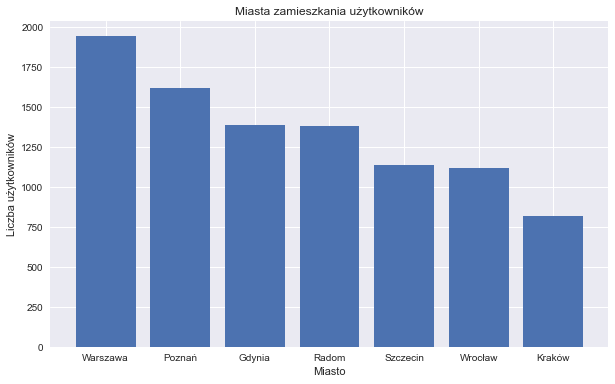

In [86]:
plt.bar(df['city'].value_counts().keys(), df['city'].value_counts())
plt.title('Miasta zamieszkania użytkowników')
plt.xlabel('Miasto')
plt.ylabel('Liczba użytkowników')

<AxesSubplot:ylabel='Miasto'>

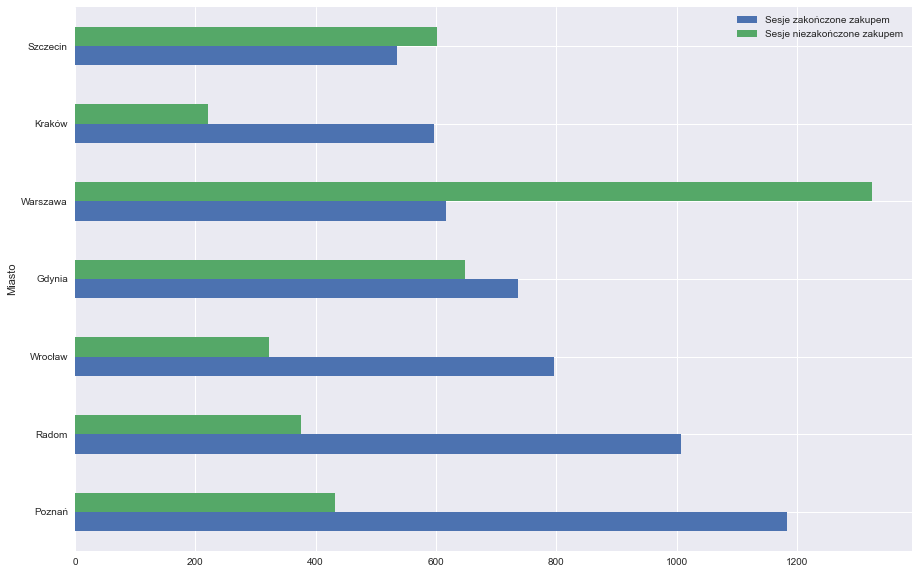

In [87]:
pd.concat([sessions_with_purchase['city'].value_counts().rename('Sesje zakończone zakupem'), sessions_without_purchase['city'].value_counts().rename('Sesje niezakończone zakupem')], axis=1).plot.barh(figsize=(15,10), xlabel='Miasto', ylabel='Liczba sesji')

Na podstawie powyższych wykresów, można dojść do ciekawych wniosków:
- Mimo tego, że jest najwięcej użytkowników z Warszawy, znaczna większość z nich nie dokonuje zakupu w sklepie.
- Miasto użytkownika niesie za sobą stosunkowo dużą informację, bo w większości miast jest wyraźna różnica między liczbą sesji zakończonych zakupem, a liczbą sesji niezakończonych zakupem

## II.9. Liczba wyświetleń produktów w trakcie sesji

In [88]:
products_not_purchased = sessions_without_purchase['product_id'].values
avg_n_views_not_purchased = np.mean([len(product_list) for product_list in products_not_purchased])
avg_n_views_not_purchased

3.8617968948841943

In [89]:
products_purchased = sessions_with_purchase['product_id'].values
avg_n_views_purchased = np.mean([len(product_list) for product_list in products_purchased])
avg_n_views_purchased

2.5418341249543297

Text(0, 0.5, 'Średnia liczba wyświetleń')

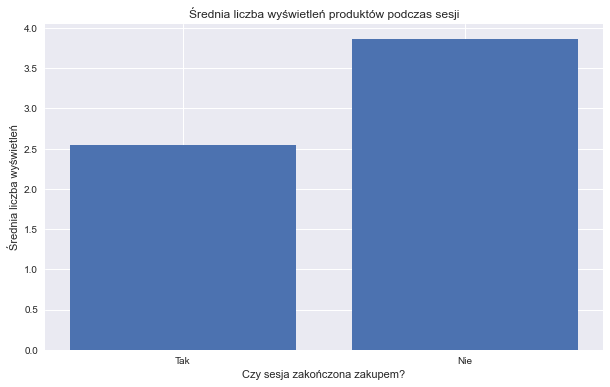

In [90]:
plt.bar(['Tak', 'Nie'], [avg_n_views_purchased, avg_n_views_not_purchased])
plt.title('Średnia liczba wyświetleń produktów podczas sesji')
plt.xlabel('Czy sesja zakończona zakupem?')
plt.ylabel('Średnia liczba wyświetleń')

Text(0, 0.5, 'Liczba sesji')

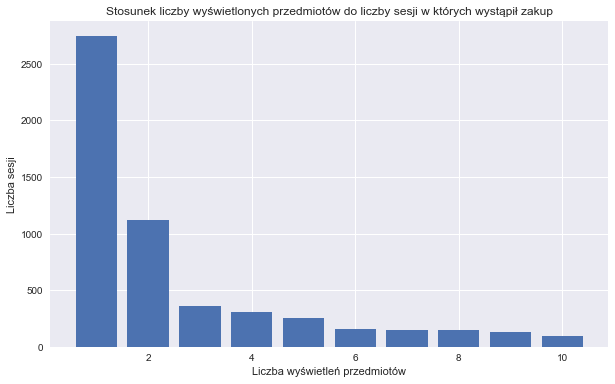

In [91]:
product_views = Counter(np.array([len(x) for x in products_purchased]))
plt.bar(product_views.keys(), product_views.values())
plt.title('Stosunek liczby wyświetlonych przedmiotów do liczby sesji w których wystąpił zakup')
plt.xlabel('Liczba wyświetleń przedmiotów')
plt.ylabel('Liczba sesji')

Z tego wynika, że istnieje tendencja taka, że im użytkownik dłużej przegląda produkty tym jest mniejsza szansa że sesja zakończy się zakupem. Wynikać to może z tego, że większośc użytkowników, którzy chcą coś kupić są zdecydowani i nie potrzebują przeglądać wiele przedmiotów. Wiele wyświetleń natomiast może znaczyć o niezdecydowaniu użytkownika - może on tylko przeglądać ofertę sklepu bez zamiaru kupna.

## II.10. Liczba sesji w każdej godzinie dla miast

### Sesje zakończone zakupem

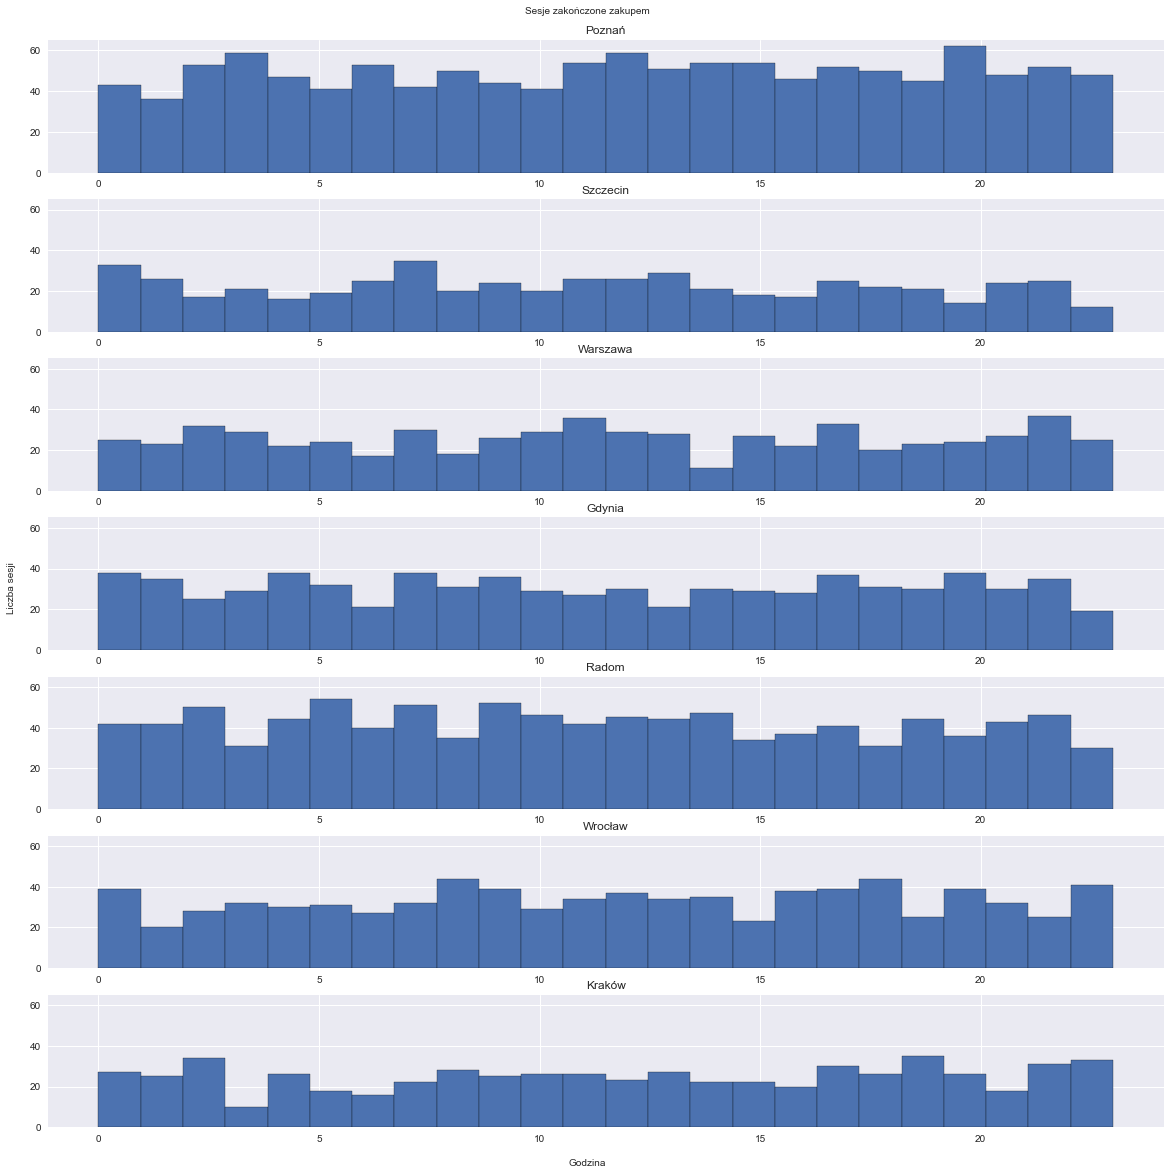

In [92]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex='row', sharey='col', figsize=(20,20))
fig.text(0.5, 0.9, 'Sesje zakończone zakupem', ha='center', va='center')
fig.text(0.5, 0.1, 'Godzina', ha='center', va='center')
fig.text(0.1, 0.5, 'Liczba sesji', ha='center', va='center', rotation='vertical')

for i, city in enumerate(df['city'].unique()):
    ax[i].hist(sessions_with_purchase.loc[sessions_with_purchase['city'] == city]['session_start'].dt.hour, bins=24, edgecolor='black')
    ax[i].set_title(city)

### Sesje niezakończone zakupem

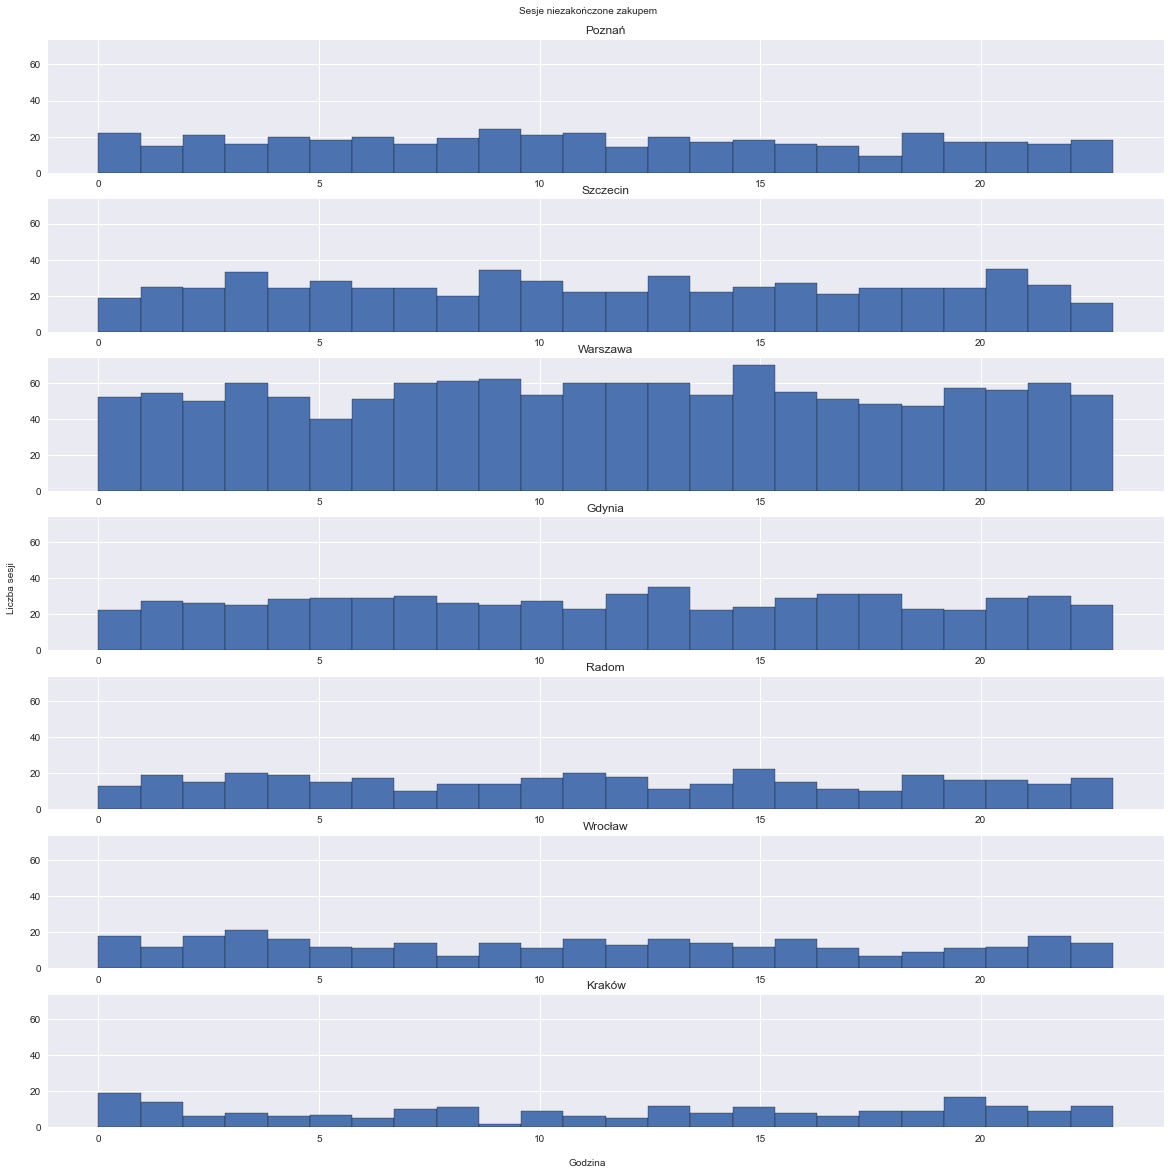

In [93]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex='row', sharey='col', figsize=(20,20))
fig.text(0.5, 0.9, 'Sesje niezakończone zakupem', ha='center', va='center')
fig.text(0.5, 0.1, 'Godzina', ha='center', va='center')
fig.text(0.1, 0.5, 'Liczba sesji', ha='center', va='center', rotation='vertical')

for i, city in enumerate(df['city'].unique()):
    ax[i].hist(sessions_without_purchase.loc[sessions_without_purchase['city'] == city]['session_start'].dt.hour, bins=24, edgecolor='black')
    ax[i].set_title(city)

Na podstawie powyższych wykresów zauważyć można pewne zależności między godziną sesji, a miastami.
Przykładowo w Warszawie najmniej sesji zakończonych zakupem zarejestrowano o godzinie 14, natomiast ta sama godzina jest jedną z najobfitszych w sesje zakończone zakupem w Poznaniu i Radomiu.

# III. Analiza sesji w kontekście zarówno produktów jak i użytkowników

## III.1. Agregacja tabel

In [99]:
df = df_sessions.merge(df_products, left_on='product_id', right_on='product_id')
df = df.merge(df_users, left_on='user_id', right_on='user_id')
df.drop(columns=['product_name'], inplace=True)
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,category_path,price,name,city,street
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
2,139,2021-07-01 11:28:02,102,1283,VIEW_PRODUCT,0,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
3,139,2021-07-01 11:31:18,102,1283,BUY_PRODUCT,0,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
4,144,2021-03-19 13:55:04,102,1283,VIEW_PRODUCT,0,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53


In [100]:
aggregation_functions = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'offered_discount' : 'first',
    'category_path' : 'unique',
    'price' : 'last',
    'city' : 'first'
}
main_df = df.groupby(df['session_id']).aggregate(aggregation_functions)
main_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [101]:
timestamp_dict = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in main_df['timestamp']]
timestamp_df = pd.DataFrame(timestamp_dict)

In [102]:
main_df = pd.concat([main_df, timestamp_df], axis=1, join="inner")
main_df.drop(columns=['timestamp'], inplace=True)
main_df.index.name = 'session_id'
main_df = main_df[['user_id', 'product_id', 'offered_discount', 'category_path', 'price', 'city', 'session_length', 'session_start', 'session_end', 'purchased']]
main_df.head()

,user_id,product_id,offered_discount,category_path,price,city,session_length,session_start,session_end,purchased
session_id,,,,,,,,,,
124,102,[1283],5,[Sprzęt RTV;Video;Telewizory i akcesoria;Okula...,99.99,Poznań,725,2021-08-26 22:27:52,2021-08-26 22:39:57,1
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,[Komputery;Drukarki i skanery;Biurowe urządzen...,3777.00,Poznań,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,1
126,102,"[1281, 1278]",15,[Sprzęt RTV;Przenośne audio i video;Odtwarzacz...,78.90,Poznań,347,2021-02-16 17:40:31,2021-02-16 17:46:18,1
127,102,"[1281, 1278]",0,[Sprzęt RTV;Przenośne audio i video;Odtwarzacz...,78.90,Poznań,457,2021-03-13 06:48:13,2021-03-13 06:55:50,1
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,[Gry i konsole;Gry na konsole;Gry Xbox 360],89.99,Poznań,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,1


## III.2. Wydane pieniądze przez użytkowników danych miast

Text(0, 0.5, 'Suma wydatków [PLN]')

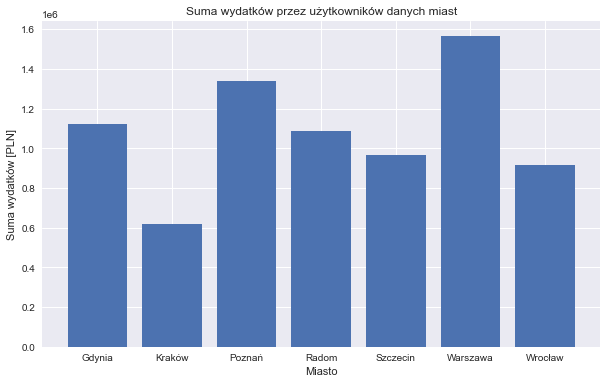

In [103]:
plt.bar(np.sort(main_df['city'].unique()), main_df.groupby(main_df['city'])['price'].agg('sum'))
plt.title('Suma wydatków przez użytkowników danych miast')
plt.xlabel('Miasto')
plt.ylabel('Suma wydatków [PLN]')

## III.3. Wydatki użytkowników pochodzących z danych miast w każdym tygodniu

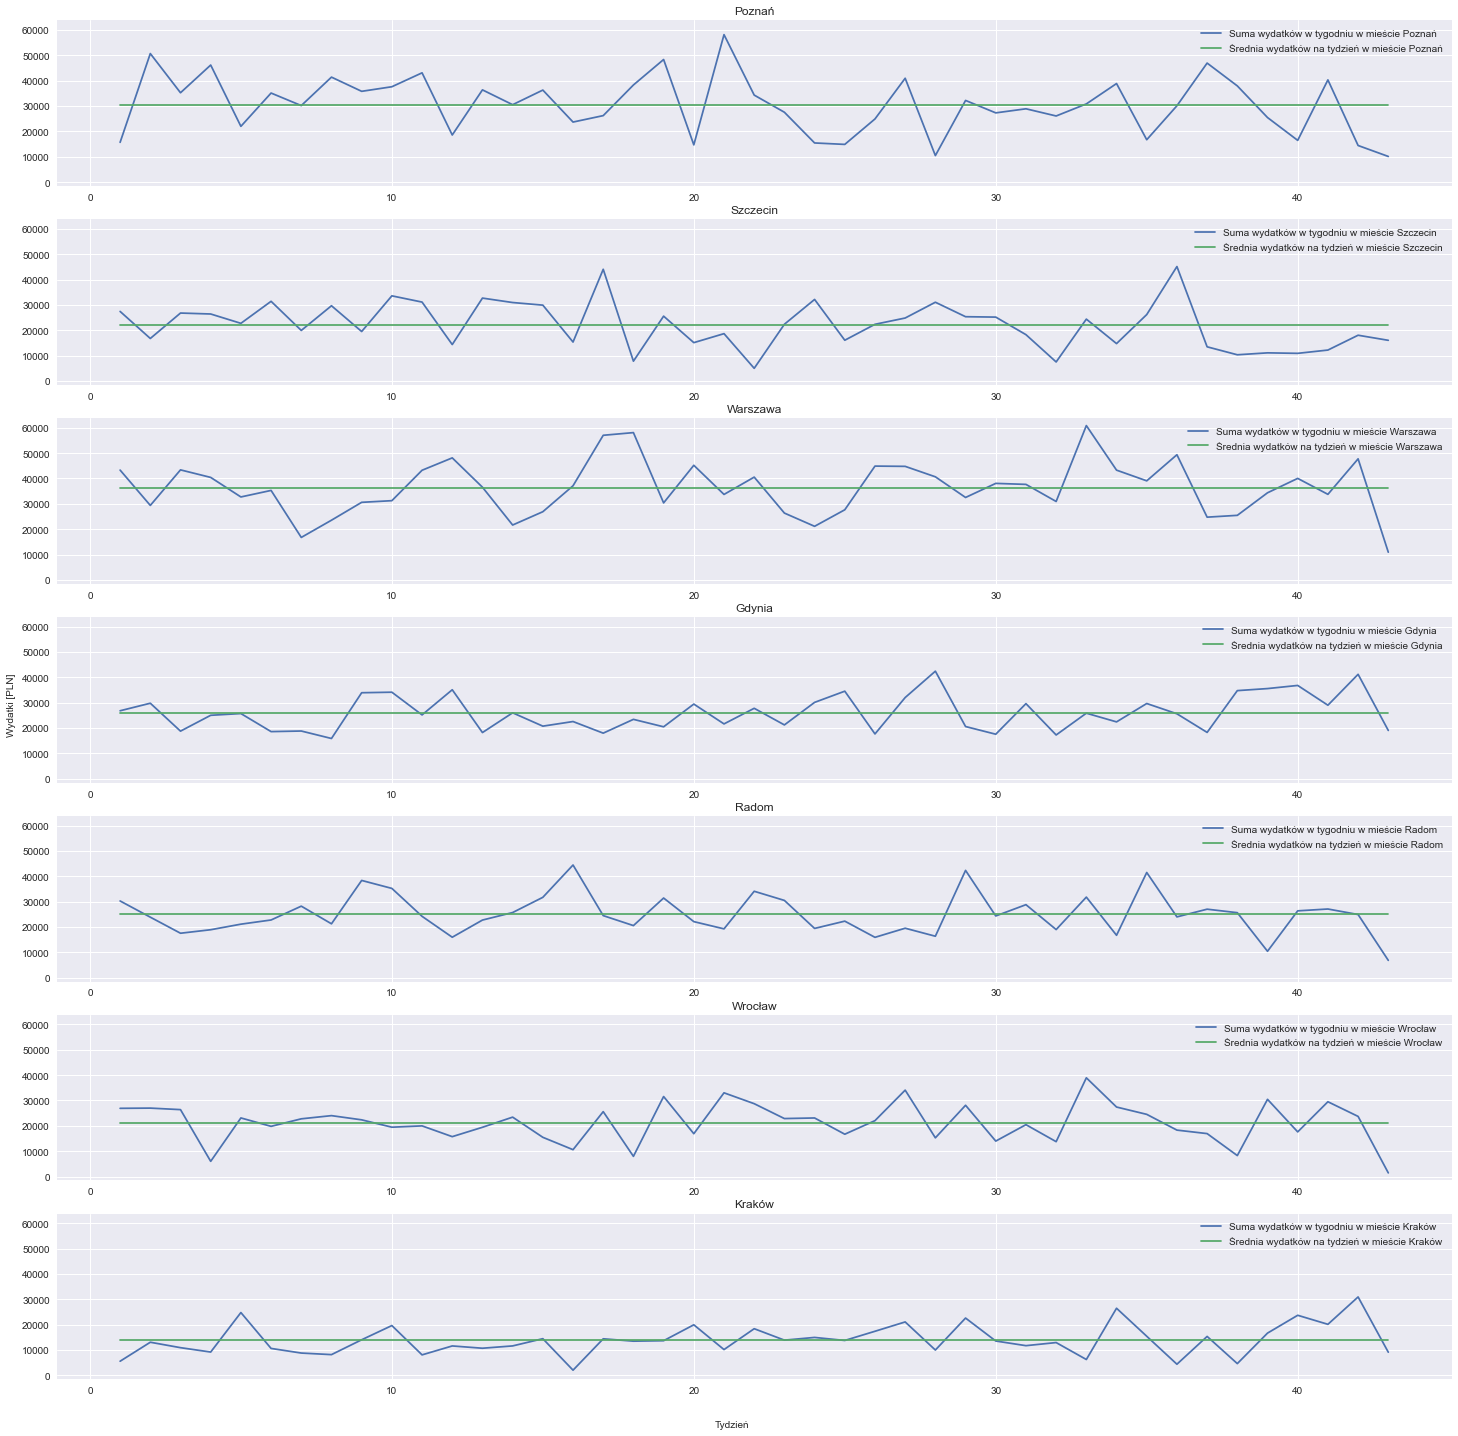

In [104]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(25,25), sharex='row', sharey='col')

fig.text(0.5, 0.1, 'Tydzień', ha='center', va='center')
fig.text(0.1, 0.5, 'Wydatki [PLN]', ha='center', va='center', rotation='vertical')
for i, city in enumerate(main_df['city'].unique()):
    ax[i].plot(
        main_df.loc[(main_df['city'] == city) & (main_df['session_start'].dt.isocalendar().week != 53)].groupby(main_df.loc[main_df['city'] == city]['session_start'].dt.isocalendar().week).aggregate({'price': 'sum'}), label=f"Suma wydatków w tygodniu w mieście {city}"
    )
    mean_by_week = main_df.loc[(main_df['city'] == city) & (main_df['session_start'].dt.isocalendar().week != 53)]['price'].sum() / 43
    ax[i].plot(np.arange(1, 44), [mean_by_week]*43, label=f"Średnia wydatków na tydzień w mieście {city}")
    ax[i].set_title(city)
    ax[i].legend()

# IV. Uwagi:
+ Rozważalibyśmy analizę sprzedaży w zależności od pory roku i miesiąca, gdybyśmy mieli dane z listopada i grudnia 2020 roku - są to dane, które potencjalnie moglibyśmy dostać od klienta biznesowego.
+ W ramach analizy nie uwzględniamy zależności między sesjami a konkretnymi produktami oraz konkretnymi użytkownikami - dodanie nowego produktu lub klienta do bazy danych sklepu (co jest częstą czynnością w przypadku sklepów e-commerce) zepsułoby nasz potencjalny model.